# Co-occurrence network

## Setup

In [1]:
## Notebook config
import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%reload_ext dotenv
%dotenv

# Global notebook imports
import os
import gc
import ast
import os
import sys
import pickle

from IPython.display import display
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

In [2]:
NEO4J_URI = os.environ.get('NEO4J_URI')
NEO4J_USER = os.environ.get('NEO4J_USER')
NEO4J_PASSWORD = os.environ.get('NEO4J_PASSWORD')


RANDOM_SEED = 42

## Neo4j projection

In [6]:
from graphdatascience import GraphDataScience


DATA_DIR = '/mnt/graphdata/lpa/' 
FEATURES_DIR =  '/mnt/graphdata/features/community' 
PROJECTION_NAME = 'virome-embeddings'


In [7]:
def get_gds_client():
    return GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def query_gds(query):
    client = get_gds_client()
    return client.run_cypher(query)

In [ ]:
def get_projection(projection_name):
    projection_query = f'''
        MATCH (t:Taxon)-[:HAS_HOST_METADATA]-(n:SRA)-[r1:HAS_SOTU]->(s:SOTU)
        WITH n, t, COUNT(distinct s) as numSOTUs
        WHERE 
            NOT (t)-[:HAS_PARENT*]->(:Taxon {{taxId: '12908'}})
            AND NOT (t)-[:HAS_PARENT*]->(:Taxon {{taxId: '410657'}})
            AND numSOTUs < 100
        OPTIONAL MATCH (n)-[r2:HAS_SOTU]->(source:SOTU)
        OPTIONAL MATCH (source)<-[:HAS_SOTU]-(n:SRA)-[:HAS_SOTU]->(target:SOTU)
        WHERE source <> target
        WITH source, target, COUNT(*) as weight
        WHERE weight > 1
        WITH gds.graph.project(
            '{projection_name}',
            source,
            target,
            {{
                relationshipProperties: {{
                    weight: weight
                }}
            }},
            {{
                undirectedRelationshipTypes: ['*']
            }}
        ) as g
        RETURN g
    '''

    projection = query_gds(projection_query)
    return projection

def delete_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        gds.graph.drop(gds.graph.get(projection_name))

# At least one common node property is needed to use the gds node export function
def add_degree_property(gds, projection_name):
    df_degree = gds.degree.mutate(
        G=gds.graph.get(projection_name),
        mutateProperty='degree',
        nodeLabels=["*"],
        relationshipTypes=["*"],
    )

gds = get_gds_client()

if gds.graph.exists(PROJECTION_NAME)['exists']:
    gds.graph.drop(gds.graph.get(PROJECTION_NAME))

projection = get_projection(PROJECTION_NAME)
add_degree_property(gds, PROJECTION_NAME)

display(projection['g'][0])

# All sOTUS
# 28623000 edges
# 513176 nodes

# sOTUs with phylogenetic neighbors 
# 11791008 edges
# 151708 nodes

# --- after fixing HAS_SOTU relationships bug
# sOTUs with phylogenetic neighbors
# 40 minutes to run
# 1,654,967,540 edges
# 151708 nodes

# sOTUs with phylogenetic neighbors and total co-occurence neighbors between [1, 100]
# 40 minutes to run
# 524,568,724 edges
# 352205 nodes

# Excluding 8802 runs with > 100 co-occurence neighbors (likely metagenomes)
# 2 minutes to run
# 57,300,844 edges
# 187729 nodes


# > 1 observation of co-occurence, < 100 co-occurence neighbors
# 2 minutes to run
# 13,041,288 edges
# 94508 nodes

# excluding ecological metagenomes, plus above
# 6 mins to run
# 6,321,024 edges
# 57099 nodes

{'relationshipCount': 6321024,
 'graphName': 'virome-embeddings',
 'query': "\n        MATCH (t:Taxon)-[:HAS_HOST_METADATA]-(n:SRA)-[r1:HAS_SOTU]->(s:SOTU)\n        WITH n, t, COUNT(distinct s) as numSOTUs\n        WHERE \n            NOT (t)-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})\n            AND NOT (t)-[:HAS_PARENT*]->(:Taxon {taxId: '410657'})\n            AND numSOTUs < 100\n        OPTIONAL MATCH (n)-[r2:HAS_SOTU]->(source:SOTU)\n        OPTIONAL MATCH (source)<-[:HAS_SOTU]-(n:SRA)-[:HAS_SOTU]->(target:SOTU)\n        WHERE source <> target\n        WITH source, target, COUNT(*) as weight\n        WHERE weight > 1\n        WITH gds.graph.project(\n            'virome-embeddings',\n            source,\n            target,\n            {\n                relationshipProperties: {\n                    weight: weight\n                }\n            },\n            {\n                undirectedRelationshipTypes: ['*']\n            }\n        ) as g\n        RETURN g\n    ",
 'projec

In [11]:
def get_wcc_communities(graph, seed_property=None, edge_weight_property=None):
    communities = gds.wcc.stream(
        graph,
        relationshipWeightProperty=edge_weight_property,
        seedProperty=seed_property,
    )
    return communities


projection = gds.graph.get(PROJECTION_NAME)
communities = get_wcc_communities(projection, edge_weight_property='weight')

if 'componentId' in communities.columns:
    communities['communityId'] = communities['componentId']

# denormalize communities using values.communityIds for multi-community nodes
if 'values' in communities.columns:
    communities['values'] = communities['values'].apply(lambda x: x['communityIds'])
    communities = communities.explode('values')
    communities['communityId'] = communities['values']
    communities = communities.drop(columns=['values'])

print('Number of communities:')
print(communities['communityId'].nunique())

print('Community sizes distribution:')
print(communities['communityId'].value_counts().describe())

print('Singletons:')
print(communities['communityId'].value_counts().loc[communities['communityId'].value_counts() == 1].count())

print('Largest community:')
print(communities['communityId'].value_counts().max())

print('top 10 communities:')
print(communities['communityId'].value_counts().head(10))

Number of communities:
1370
Community sizes distribution:
count     1370.000000
mean        41.678102
std       1500.556532
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      55542.000000
Name: count, dtype: float64
Singletons:
1228
Largest community:
55542
top 10 communities:
communityId
0        55542
38700       10
55803        6
54645        5
25316        4
54069        4
43765        4
53049        4
55245        4
49205        4
Name: count, dtype: int64


In [ ]:
# Export nodes from projection to df

DATA_DIR = '../../../../data'
FEATURES_DIR = f'{DATA_DIR}/features'

def export_nodes_from_projection(property, projection_name=PROJECTION_NAME):
    nodes = gds.graph.nodeProperties.stream(
        gds.graph.get(projection_name),
        node_properties=[property],
        separate_property_columns=True,
        db_node_properties=[
            'sotu',
            'taxPhylum',
            'taxFamily',
            'taxOrder',
            'taxGenus',
            'taxSpecies',
        ],
        listNodeLabels=True,
    )
    nodes['nodeLabels'] = nodes['nodeLabels'].apply(lambda x: x[0])

    nodes.to_csv(f'{DATA_DIR}/co-occurrence-sotu-nodes.csv', index=False)
    return nodes


df_nodes = export_nodes_from_projection('degree')

In [ ]:
# Export dataset edges from projection
def export_edges_from_projection(projection_name=PROJECTION_NAME):
    edges = gds.graph.relationshipProperties.stream(
        gds.graph.get(projection_name),
        relationship_properties=['weight'],
    )
    nodeId_to_sotu = df_nodes[['nodeId', 'sotu']].set_index('nodeId').to_dict()['sotu']
    edges['sourceAppId'] = edges['sourceNodeId'].map(nodeId_to_sotu)
    edges['targetAppId'] = edges['targetNodeId'].map(nodeId_to_sotu)
    edges = edges.sort_values('relationshipProperty', ascending=False)
    edges.to_csv(f'{DATA_DIR}/co-occurrence-sotu-edges.csv', index=False)
    return edges

edges_df = export_edges_from_projection()

[#81B2]  _: <CONNECTION> error: Failed to read from defunct connection IPv4Address(('44.221.248.196', 7687)) (ResolvedIPv4Address(('44.221.248.196', 7687))): SocketDeadlineExceededError('timed out')
Unable to connect to the Neo4j DBMS. Trying again...


In [ ]:
# Tmp: additional data for plotting

import os

from neo4j import GraphDatabase

class Neo4jConnection:
    def __init__(self, uri, user, pwd):
        self._uri = uri
        self._user = user
        self._pwd = pwd
        self._driver = None
        try:
            self._driver = GraphDatabase.driver(
                self._uri, auth=(self._user, self._pwd))
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):
        if self._driver is not None:
            self._driver.close()

    def query(self, query, parameters=None, db=None):
        assert self._driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            session = self._driver.session(
                database=db) if db is not None else self._driver.session()
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response


def get_connection():
    return Neo4jConnection(
        uri=os.environ.get('NEO4J_URI'),
        user=os.environ.get('NEO4J_USER'),
        pwd=os.environ.get('NEO4J_PASSWORD')
    )

def get_human_associated_sotus():
    data_dir = '../../../../data'
    if os.path.exists(f'{data_dir}/human-associated-sotus.csv'):
        return pd.read_csv(f'{data_dir}/human-associated-sotus.csv')
    
    connection = get_connection()
    query = '''
        MATCH (s:SOTU)<-[:HAS_SOTU]-(n:SRA)-[:HAS_HOST_METADATA]->(t:Taxon)
        WHERE t.taxId = '9606'
        RETURN DISTINCT s.sotu
    '''
    result = connection.query(query)
    connection.close()
    human_associated_sotus_df = pd.DataFrame(result, columns=['sotu'])
    human_associated_sotus_df.to_csv(f'{data_dir}/human-associated-sotus.csv', index=False)
    return human_associated_sotus_df


def get_tax_id_to_scientific_name():
    data_dir = '../../../../data'
    if os.path.exists(f'{data_dir}/tax_id_names.csv'):
        return pd.read_csv(f'{data_dir}/tax_id_names.csv')
    
    connection = get_connection()
    query = '''
        MATCH (t:Taxon)
        RETURN 
            t.taxId as taxId,
            CASE t.rank
                WHEN 'species' THEN t.taxSpecies 
                WHEN 'genus' THEN t.taxGenus
                WHEN 'family' THEN t.taxFamily
                WHEN 'order' THEN t.taxOrder
                WHEN 'phylum' THEN t.taxPhylum
                WHEN 'class' THEN t.taxClass
                WHEN 'kingdom' THEN t.taxKingdom
                ELSE 'N/A'
            END as scientificName
    '''
    result = connection.query(query)
    connection.close()
    tax_id_to_scientific_name_df = pd.DataFrame(result, columns=['taxId', 'scientificName'])
    tax_id_to_scientific_name_df.to_csv(f'{data_dir}/tax_id_names.csv', index=False)
    return tax_id_to_scientific_name_df


get_tax_id_to_scientific_name()


## PyG Link prediction 

#### Setup and config

In [63]:
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import torch.nn as nn
from torch_geometric import seed_everything
from torch_geometric.data import HeteroData, Data
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.utils import to_networkx, degree, mask_select, dropout_edge, remove_isolated_nodes, subgraph
from torch_geometric.nn import SAGEConv, GATConv, GCNConv, to_hetero, MIPSKNNIndex, BatchNorm, GraphSAGE
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.metrics import (
    LinkPredMAP,
    LinkPredPrecision,
    LinkPredRecall,
)

In [73]:
# Config vars

# Download dataset in sibling dir of repo: `aws s3 cp --recursive s3://serratus-graph/dataset/ ../data`
DATA_DIR = '../../../../data'
FEATURES_DIR = f'{DATA_DIR}/features'
MODEL_DIR = f'{DATA_DIR}/models'
RANDOM_SEED = 42

seed_everything(RANDOM_SEED)

MODEL_CONFIG = {
    'USE_UNSUPERVISED_MODEL': False, # False,
    'MODEL_HIDDEN_DIM': 384, # 384,
    'MODEL_OUT_DIM': 128, # 128,
    'MODEL_LAYERS': 3, # 5,
    'LEARNING_RATE': 0.001,
    'L2_REG': 0.01, # 0.01,
    'DROPOUT_RATE': 0.1, #0.3, #0.2, #0.4, 
    'FP_ITERS': 3,
}

TRAINING_CONFIG = {
    'NEGATIVE_SAMPLING_RATIO': 20,
    'TEST_FRACTION': 0.3,
    'VAL_FRACTION': 0.0,
    'TARGET_NODE': 'sotu',
    'TARGET_EDGE': ('sotu', 'co_occur', 'sotu'),
    'EDGE_THRESHOLD': 2, #4, # 0.015, # 0.9,
    'SEED': 42,
    'BATCH_SIZE': 4096, # 2048, 8192,
    'NUM_WORKERS': 24,
    'NUM_NEIGHBORS': [-1, -1, 20], #[-1, -1, 20],
    'MAX_EPOCHS': 5,
    'MIN_EPOCHS': 0,
    'REDUCED_FT_DIM': float('inf'), #float('inf'),
    'REMOVE_ISOLATED_NODES': True,
    'FEATURES': {
        'TOP_GENBANK_HIT': [1], # [1]
        'STAT_ORGANISM': [3], # [3]
        'TISSUE': [0, 2], # [0, 2]
        'BIOME': [0], # [0]
    }
}

TRAINING_CONFIG['TRAIN_FRACTION'] = 1 - TRAINING_CONFIG['TEST_FRACTION'] - TRAINING_CONFIG['VAL_FRACTION']

# device  = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def clear_cuda_mem():
    torch.cuda.empty_cache()
    gc.collect()

def print_config_vars():
    print(f'Using device: {device}, current device: {torch.cuda.current_device()}')
    print(f"Model config:")
    display(MODEL_CONFIG)
    print(f"Training config:")
    display(TRAINING_CONFIG)
    print()

clear_cuda_mem()
print_config_vars()

Using device: cuda, current device: 0
Model config:


{'USE_UNSUPERVISED_MODEL': False,
 'MODEL_HIDDEN_DIM': 384,
 'MODEL_OUT_DIM': 128,
 'MODEL_LAYERS': 3,
 'LEARNING_RATE': 0.001,
 'L2_REG': 0.01,
 'DROPOUT_RATE': 0.1,
 'FP_ITERS': 3}

Training config:


{'NEGATIVE_SAMPLING_RATIO': 20,
 'TEST_FRACTION': 0.3,
 'VAL_FRACTION': 0.0,
 'TARGET_NODE': 'sotu',
 'TARGET_EDGE': ('sotu', 'co_occur', 'sotu'),
 'EDGE_THRESHOLD': 2,
 'SEED': 42,
 'BATCH_SIZE': 4096,
 'NUM_WORKERS': 24,
 'NUM_NEIGHBORS': [-1, -1, 20],
 'MAX_EPOCHS': 5,
 'MIN_EPOCHS': 0,
 'REDUCED_FT_DIM': inf,
 'REMOVE_ISOLATED_NODES': True,
 'FEATURES': {'TOP_GENBANK_HIT': [1],
  'STAT_ORGANISM': [3],
  'TISSUE': [0, 2],
  'BIOME': [0]},
 'TRAIN_FRACTION': 0.7}

#### Helper function defitions

In [74]:
# Helpers: Feature encoding

class IdentityEncoder(object):
    def __init__(self, dtype=None, is_list=False, is_tensor=False):
        self.dtype = dtype
        self.is_list = is_list
        self.is_tensor = is_tensor

    def __call__(self, df):
        if self.is_tensor:
            if self.is_list:
                return torch.stack([torch.tensor([el]) for el in df.values])
            return torch.from_numpy(df.values).to(self.dtype)
        else:
            return df

class ListEncoder(object):
    def __init__(self, sep=',', is_tensor=False):
        self.sep = sep
        self.is_tensor = is_tensor

    def __call__(self, df):
        eval_df = df.apply(
            lambda x: [val for val in ast.literal_eval(x)])
        return torch.stack([torch.tensor(el) for el in eval_df.values])

class LabelEncoder(object):
    def __init__(self, sep=',', is_tensor=False, mapping=None):
        self.sep = sep
        self.is_tensor = is_tensor
        self.mapping = mapping

    def __call__(self, df):
        mapping = self.mapping
        if self.is_tensor:
            if not mapping:
                labels = set(
                    label for col in df.values
                    for label in col.split(self.sep)
                )
                mapping = {label: i for i, label in enumerate(labels)}
            x = torch.zeros(len(df), len(mapping))
            for i, col in enumerate(df.values):
                for label in col.split(self.sep):
                    x[i, mapping[label]] = 1
            return x
        if not mapping:
            labels = df[df.columns[0]].unique()
            mapping = {label: i for i, label in enumerate(labels)}
        return df.replace(mapping)


def load_node_tensor(df, index_col, encoders=None):
    mapping = {index: i for i, index in enumerate(df[index_col].unique())}
    x = torch.zeros(size=(len(df.index), 1))

    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)
        x = x.float()
    
    assert len(mapping) == len(df.index.unique())
    return x, mapping


def load_edge_tensor(df, src_index_col, src_mapping,
                     dst_index_col, dst_mapping, encoders=None):
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])
    edge_attr = None
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr


def get_label_from_communities(communities, level=0):
    if 'intermediateCommunityIds' not in communities.columns:
        communities['targetLevel'] = communities['communityId']
    else:    
        communities['targetLevel'] = communities['intermediateCommunityIds'].apply(lambda x: ast.literal_eval(x)[level])
    return communities


def get_multi_class_encoding(sotu_nodes, md_mapping, md_fts, md_key):
    sotu_fts = pd.merge(
        md_mapping,
        md_fts[['nodeId', 'appId', 'targetLevel']],
        left_on=md_key, 
        right_on='appId',
        how='left')
    sotu_fts = pd.merge(
        sotu_nodes,
        sotu_fts[['sotu', 'targetLevel']],
        left_on='sotu', 
        right_on='sotu',
        how='left')
    # fill missing values with max targetLevel + 1
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].fillna(sotu_fts['targetLevel'].max() + 1)
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].astype(int)
    sotu_fts = sotu_fts.groupby('sotu')['targetLevel'].apply(list).reset_index()

    # convert to one-hot encoding using MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    sotu_fts['targetLevel'] = mlb.fit_transform(sotu_fts['targetLevel']).tolist()
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].astype(str)

    return sotu_fts, mlb.classes_


def get_node_features(sotu_nodes, feature_type, hierarchy_level):
    if os.path.exists(f'{FEATURES_DIR}/{feature_type}_level_{hierarchy_level}.pt'):
        sotu_x = torch.load(f'{FEATURES_DIR}/{feature_type}_level_{hierarchy_level}.pt')
        sotu_mapping = torch.load(f'{FEATURES_DIR}/{feature_type}_level_{hierarchy_level}_sotu_mapping.pt')
        label_mapping = torch.load(f'{FEATURES_DIR}/{feature_type}_level_{hierarchy_level}_label_mapping.pt')
        return sotu_x, sotu_mapping, label_mapping
    
    if feature_type == 'TISSUE':
        encoding_df = pd.read_csv(f'{DATA_DIR}/tissue_leiden_communities.csv', index_col=False)
        metadata_mapping = pd.read_csv(f'{DATA_DIR}/sotu_tissues.csv', index_col=False)
        md_key = 'btoId'
    elif feature_type == 'TOP_GENBANK_HIT':
        encoding_df = pd.read_csv(f'{DATA_DIR}/taxon_leiden_communities.csv', index_col=False) 
        metadata_mapping = pd.read_csv(f'{DATA_DIR}/sotu_has_inferred_taxon_edges.csv', index_col=False)
        metadata_mapping = metadata_mapping.rename(columns={'targetAppId': 'taxId', 'sourceNode': 'nodeId', 'sourceAppId': 'sotu'})
        md_key = 'taxId'
    elif feature_type == 'STAT_ORGANISM':
        encoding_df = pd.read_csv(f'{DATA_DIR}/taxon_leiden_communities.csv', index_col=False) 
        metadata_mapping = pd.read_csv(f'{DATA_DIR}/sotu_has_host_stat_edges.csv', index_col=False)
        metadata_mapping = metadata_mapping.rename(columns={'targetAppId': 'taxId', 'sourceNode': 'nodeId', 'sourceAppId': 'sotu'})
        md_key = 'taxId'
    elif feature_type == 'BIOME':
        metadata_mapping = pd.read_csv(f'{DATA_DIR}/sotu_biome.csv', index_col=False)
        biome_id_map = {}
        for biome in metadata_mapping['biomeId'].unique():
            biome_id_map[biome] = biome_id_map.get(biome, len(biome_id_map))
        encoding_df_rows = []
        for biome_label, biome_id in biome_id_map.items():
            encoding_df_rows.append({
                'biome': biome_label,
                'communityId': biome_id,
                'intermediateCommunityIds': [biome_id] * 5,
            })
        encoding_df = pd.DataFrame(encoding_df_rows)
        encoding_df['intermediateCommunityIds'] = encoding_df['intermediateCommunityIds'].apply(str)
        encoding_df['appId'] = encoding_df['biome']
        encoding_df['nodeId'] = encoding_df['communityId']
        md_key = 'biomeId'
    else:
        return
    
    encoding_df = get_label_from_communities(encoding_df, level=hierarchy_level)
    sotu_fts, label_mapping = get_multi_class_encoding(sotu_nodes, metadata_mapping, encoding_df, md_key)
    sotu_fts = sotu_fts.rename(columns={'targetLevel': feature_type})
    sotu_fts = pd.merge(sotu_nodes, sotu_fts, left_on='sotu', right_on='sotu', how='left')

    sotu_x, sotu_mapping = load_node_tensor(
        df=sotu_fts,
        index_col='sotu',
        encoders={
            feature_type: ListEncoder(is_tensor=True)
        }
    )
    torch.save(sotu_x, f'{FEATURES_DIR}/{feature_type}_level_{hierarchy_level}.pt')
    torch.save(sotu_mapping, f'{FEATURES_DIR}/{feature_type}_level_{hierarchy_level}_sotu_mapping.pt')
    torch.save(label_mapping, f'{FEATURES_DIR}/{feature_type}_level_{hierarchy_level}_label_mapping.pt')

    return sotu_x, sotu_mapping, label_mapping

def get_reduced_features(data, out_channels=TRAINING_CONFIG['REDUCED_FT_DIM']):
    out_channels = 512

    if data['sotu'].x.size(-1) > out_channels:
        U, S, _ = torch.linalg.svd(data['sotu'].x, full_matrices=False)
        data['sotu'].x = torch.mm(U[:, :out_channels],
        torch.diag(S[:out_channels]))
    return data


def get_top_sotu_labels(sotu_id, k=1):
    sotu_tissues = pd.read_csv(f'{DATA_DIR}/sotu_tissues.csv')
    sotu_host_stat = pd.read_csv(f'{DATA_DIR}/sotu_has_host_stat_edges.csv')
    sotu_biome = pd.read_csv(f'{DATA_DIR}/sotu_biome.csv')
    sotu_genbank = pd.read_csv(f'{DATA_DIR}/sotu_has_inferred_taxon_edges.csv')
    tax_id_names = pd.read_csv(f'{DATA_DIR}/tax_id_names.csv')


    sotu_tissues = sotu_tissues[sotu_tissues['sotu'] == sotu_id]
    sotu_host_stat = sotu_host_stat[sotu_host_stat['sourceAppId'] == sotu_id]
    sotu_biome = sotu_biome[sotu_biome['sotu'] == sotu_id]
    sotu_genbank = sotu_genbank[sotu_genbank['sourceAppId'] == sotu_id]

    # get top labels
    top_tissue = sotu_tissues['scientificName'].value_counts().index[:k].tolist()
    top_biome = sotu_biome['biomeName'].value_counts().index[:k].tolist()
    top_host_stat = sotu_host_stat['targetAppId'].value_counts().index[:k].tolist()
    top_host_stat = tax_id_names[tax_id_names['taxId'].isin(top_host_stat)]['scientificName'].tolist()
    top_genbank = sotu_genbank['targetAppId'].value_counts().index[:k].tolist()
    top_genbank = tax_id_names[tax_id_names['taxId'].isin(top_genbank)]['scientificName'].tolist()

    return top_tissue, top_host_stat, top_biome, top_genbank



In [75]:
# Helpers: Create base pytorch geometric graph + feature eng

def run_feature_propagation(data, fp_iterations=MODEL_CONFIG['FP_ITERS']):
    missing_mask = data.x == 0
    transform = T.FeaturePropagation(missing_mask=missing_mask, num_iterations=fp_iterations)
    data = transform(data)
    return data


def add_reverse_edges(data):
    data = T.ToUndirected(merge=False)(data)
    # Remove "reverse" label (redundant when using link loader)
    rev_edge = (TRAINING_CONFIG['TARGET_EDGE'][2], f'rev_{TRAINING_CONFIG['TARGET_EDGE'][1]}', TRAINING_CONFIG['TARGET_EDGE'][0])
    del data[rev_edge].edge_label

    bug_edge = (TRAINING_CONFIG['TARGET_EDGE'][0], f'rev_rev_{TRAINING_CONFIG['TARGET_EDGE'][1]}', TRAINING_CONFIG['TARGET_EDGE'][2])
    if bug_edge in data.edge_types:
        del data[bug_edge]
    return data


def fp_on_phylo(data, sotu_mapping, fp_iterations=MODEL_CONFIG['FP_ITERS']):
    sotu_seq_alignment_edges = pd.read_csv(f'{DATA_DIR}/sotu_sequence_alignment_edges.csv', index_col=False)
    sotu_seq_alignment_edges = sotu_seq_alignment_edges[
        sotu_seq_alignment_edges['sourceAppId'].isin(sotu_mapping) &
        sotu_seq_alignment_edges['targetAppId'].isin(sotu_mapping)
    ]
    sotu_seq_alignment_edges = sotu_seq_alignment_edges[sotu_seq_alignment_edges['weight'] > 0]

    sotu_seq_alignment_edge_index, sotu_seq_alignment_edge_attr = load_edge_tensor(
        df=sotu_seq_alignment_edges,
        src_index_col='sourceAppId',
        src_mapping=sotu_mapping,
        dst_index_col='targetAppId',
        dst_mapping=sotu_mapping,
        encoders={
            'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
        } 
    )
    data_copy = Data()
    data_copy.x = data['sotu'].x
    data_copy.edge_index = sotu_seq_alignment_edge_index
    data_copy.edge_attr = sotu_seq_alignment_edge_attr
    data_copy = run_feature_propagation(data_copy, fp_iterations=fp_iterations)
    data['sotu'].x = data_copy.x
    return data


def get_augmented_co_occurrence_edges():
    sotu_nodes = pd.read_csv(f'{DATA_DIR}/palm_virome_sotu.csv', index_col=False)
    sotu_co_occurrence_nodes = pd.read_csv(f'{DATA_DIR}/co-occurrence-sotu-nodes.csv', index_col=False)
    sotu_co_occurrence_nodes = sotu_co_occurrence_nodes[
        sotu_co_occurrence_nodes['sotu'].isin(sotu_nodes['sotu'])
    ]
    sotu_co_occurrence_edges = pd.read_csv(f'{DATA_DIR}/co-occurrence-sotu-edges.csv', index_col=False)
    sotu_co_occurrence_edges = sotu_co_occurrence_edges[
        sotu_co_occurrence_edges['sourceAppId'].isin(sotu_nodes['sotu']) &
        sotu_co_occurrence_edges['targetAppId'].isin(sotu_nodes['sotu'])
    ]
    sotu_co_occurrence_edges['pair'] = sotu_co_occurrence_edges.apply(
        lambda row: tuple(sorted((row['sourceAppId'], row['targetAppId']))), axis=1
    )
    sotu_co_occurrence_edges = sotu_co_occurrence_edges.drop_duplicates(subset='pair').drop(columns='pair')

    # for each sotu, sum relationshipProperty where sotu is in source or target
    source_total_degree = sotu_co_occurrence_edges.groupby('sourceAppId')['propertyValue'].sum().reset_index()
    source_total_degree = source_total_degree.rename(columns={'sourceAppId': 'sotu'})
    target_total_degree = sotu_co_occurrence_edges.groupby('targetAppId')['propertyValue'].sum().reset_index()
    target_total_degree = target_total_degree.rename(columns={'targetAppId': 'sotu'})

    total_degree_count = pd.concat([source_total_degree, target_total_degree])
    total_degree_count = total_degree_count.groupby('sotu')['propertyValue'].sum().reset_index()
    total_degree_count = total_degree_count.rename(columns={'propertyValue': 'totalDegreeCount'})

    # for each edge, divide relationshipProperty by totalDegreeCount
    sotu_co_occurrence_edges = pd.merge(
        sotu_co_occurrence_edges,
        total_degree_count[['sotu', 'totalDegreeCount']],
        left_on='sourceAppId',
        right_on='sotu',
        how='left'
    )
    sotu_co_occurrence_edges = pd.merge(
        sotu_co_occurrence_edges,
        total_degree_count[['sotu', 'totalDegreeCount']],
        left_on='targetAppId',
        right_on='sotu',
        how='left',
        suffixes=('_source', '_target')
    )
    sotu_co_occurrence_edges['weight'] = sotu_co_occurrence_edges['propertyValue'] / (sotu_co_occurrence_edges['totalDegreeCount_source'] + sotu_co_occurrence_edges['totalDegreeCount_target'])
    sotu_co_occurrence_edges = sotu_co_occurrence_edges.drop(columns=['sotu_source', 'sotu_target', 'totalDegreeCount_source', 'totalDegreeCount_target'])

    # curve weight to gaussian 
    std = sotu_co_occurrence_edges['weight'].std()
    mean = sotu_co_occurrence_edges['weight'].mean()
    sotu_co_occurrence_edges['weight'] = sotu_co_occurrence_edges['weight'].apply(lambda x: np.exp(-((x - mean) ** 2) / (2 * std ** 2)))
    
    # print(sotu_co_occurrence_edges.shape)
    # print(sotu_co_occurrence_edges['weight'].describe())
    plt.hist(sotu_co_occurrence_edges['weight'], bins=100)
    plt.yscale('log')
    plt.show()
    return sotu_co_occurrence_edges


def create_pyg_graph():
    data = HeteroData()
    mappings = {}

    print('A')
    # sotu_nodes = pd.read_csv(f'{DATA_DIR}/sotu_nodes.csv', index_col=False)
    sotu_nodes = pd.read_csv(f'{DATA_DIR}/palm_virome_sotu.csv', index_col=False)

    xs = []
    for feature_type, hierarchy_levels in TRAINING_CONFIG['FEATURES'].items():
        for hierarchy_level in hierarchy_levels:
            sotu_x, sotu_mapping, label_mapping = get_node_features(sotu_nodes, feature_type, hierarchy_level)
            xs.append(sotu_x)
            mappings[feature_type] = label_mapping


    mappings['sotu'] = sotu_mapping
    data['sotu'].x = torch.cat(xs, dim=-1)
    print(f'SOTU nodes: {data["sotu"].x.shape}')


    if MODEL_CONFIG['FP_ITERS'] > 0:
        data = fp_on_phylo(data, mappings['sotu'], fp_iterations=MODEL_CONFIG['FP_ITERS'])
    
    # sotu_co_occurrence_edges = get_augmented_co_occurrence_edges()
    sotu_co_occurrence_edges = pd.read_csv(f'{DATA_DIR}/co-occurrence-sotu-edges.csv', index_col=False)
    sotu_co_occurrence_edges = sotu_co_occurrence_edges[
        sotu_co_occurrence_edges['sourceAppId'].isin(mappings['sotu']) &
        sotu_co_occurrence_edges['targetAppId'].isin(mappings['sotu'])
    ]

    if 'propertyValue' in sotu_co_occurrence_edges.columns and 'weight' not in sotu_co_occurrence_edges.columns:
        sotu_co_occurrence_edges = sotu_co_occurrence_edges.rename(columns={'propertyValue': 'weight'})

    if TRAINING_CONFIG['EDGE_THRESHOLD'] > 0:
        sotu_co_occurrence_edges = sotu_co_occurrence_edges[sotu_co_occurrence_edges['weight'] > TRAINING_CONFIG['EDGE_THRESHOLD']]
    
    # remove duplicate edges with source and target reversed without <  comparison
    sotu_co_occurrence_edges['pair'] = sotu_co_occurrence_edges.apply(
        lambda row: tuple(sorted((row['sourceAppId'], row['targetAppId']))), axis=1
    )
    sotu_co_occurrence_edges = sotu_co_occurrence_edges.drop_duplicates(subset='pair').drop(columns='pair')

    sotu_co_occurrence_edge_index, sotu_co_occurrence_edge_attr = load_edge_tensor(
        df=sotu_co_occurrence_edges,
        src_index_col='sourceAppId',
        src_mapping=mappings['sotu'],
        dst_index_col='targetAppId',
        dst_mapping=mappings['sotu'],
        encoders={
            'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
        } 
    )
    data['sotu', 'co_occur', 'sotu'].edge_index = sotu_co_occurrence_edge_index
    data['sotu', 'co_occur', 'sotu'].edge_attr = sotu_co_occurrence_edge_attr
    print(f'SOTU edges: {sotu_co_occurrence_edge_index.shape}')

    data = add_reverse_edges(data)

    if TRAINING_CONFIG['REMOVE_ISOLATED_NODES']:
        transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
        data = transform(data)

    if data['sotu'].x.size(-1) > TRAINING_CONFIG['REDUCED_FT_DIM']:
        data = get_reduced_features(data, out_channels=TRAINING_CONFIG['REDUCED_FT_DIM'])


    return data, mappings

In [76]:
# Helpers: Split data, init data loaders

def split_data(data):
    num_test = TRAINING_CONFIG['TEST_FRACTION']
    num_val = TRAINING_CONFIG['VAL_FRACTION']

    transform = T.RandomLinkSplit(
        num_val=num_val,
        num_test=num_test,
        # is_undirected=True,
        # Of training edges, use 70% for message passing (edge_index)
        # and 30% for supervision (edge_label_index)
        # disjoint_train_ratio=0.3,
        # Generate fixed negative edges in validation and test data
        neg_sampling_ratio=TRAINING_CONFIG['NEGATIVE_SAMPLING_RATIO'],
        # Don't generate negative edges in training set, will be generated by LinkNeighborLoader.
        add_negative_train_samples=False,
        edge_types=TRAINING_CONFIG['TARGET_EDGE'],
        rev_edge_types=(TRAINING_CONFIG['TARGET_EDGE'][2], f'rev_{TRAINING_CONFIG['TARGET_EDGE'][1]}', TRAINING_CONFIG['TARGET_EDGE'][0]),
    )
    train_data, val_data, test_data = transform(data)
    ref_data = data.clone()
    return train_data, val_data, test_data, ref_data

def get_train_loader(split_data, batch_size=TRAINING_CONFIG['BATCH_SIZE']):
    edge_label_index = split_data[TRAINING_CONFIG['TARGET_EDGE']].edge_label_index
    edge_label = split_data[TRAINING_CONFIG['TARGET_EDGE']].edge_label

    train_loader = LinkNeighborLoader(
        data=split_data,
        num_neighbors=TRAINING_CONFIG['NUM_NEIGHBORS'], 
        neg_sampling=dict(mode='binary', amount=TRAINING_CONFIG['NEGATIVE_SAMPLING_RATIO']),
        edge_label=edge_label,
        edge_label_index=(TRAINING_CONFIG['TARGET_EDGE'], edge_label_index),
        batch_size=batch_size,
        shuffle=True,
        num_workers=TRAINING_CONFIG['NUM_WORKERS'],
        # drop_last=True,
    )
    return train_loader

def get_val_loader(split_data, batch_size=TRAINING_CONFIG['BATCH_SIZE']):
    edge_label_index = split_data[TRAINING_CONFIG['TARGET_EDGE']].edge_label_index
    edge_label = split_data[TRAINING_CONFIG['TARGET_EDGE']].edge_label

    val_loader = LinkNeighborLoader(
        data=split_data,
        num_neighbors=TRAINING_CONFIG['NUM_NEIGHBORS'],
        edge_label_index=(TRAINING_CONFIG['TARGET_EDGE'], edge_label_index),
        edge_label=edge_label,
        batch_size=batch_size,
        shuffle=False,
        num_workers=TRAINING_CONFIG['NUM_WORKERS'],
        # drop_last=True,
        # neighbor_sampler=custom_node_sampler,
    )
    return val_loader

In [77]:
# Create model (v1)

# Recommender system sage example:
# https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/recommender_system.py

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, dropout=MODEL_CONFIG['DROPOUT_RATE']):
        super().__init__()
        self.dropout = dropout
        self.conv_layer = SAGEConv # SAGEConv, GATConv, GCNConv,

        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()

        self.convs.append(self.conv_layer((-1, -1), hidden_channels))
        self.batch_norms.append(BatchNorm(hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(self.conv_layer(hidden_channels, hidden_channels))
            self.batch_norms.append(BatchNorm(hidden_channels))

        self.convs.append(self.conv_layer(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for conv, batch_norm in zip(self.convs[:-1], self.batch_norms):
            x = conv(x, edge_index)
            # x = batch_norm(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.convs[-1](x, edge_index)

class EdgeDecoder(torch.nn.Module):
    def forward(self, z_dict, edge_label_index, target_edge=TRAINING_CONFIG['TARGET_EDGE']):
        x_src = z_dict[target_edge[0]][edge_label_index[0]]
        x_dst = z_dict[target_edge[2]][edge_label_index[1]]
        return (x_src * x_dst).sum(dim=-1)


class ModelV1(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, data):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, out_channels, num_layers)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder()
        self.data = data

    def forward(self, x_dict, edge_index_dict, edge_label_index, target_edge=TRAINING_CONFIG['TARGET_EDGE']):
        z_dict = self.encoder(x_dict, edge_index_dict)
        self.data.to(device)

        return self.decoder(z_dict, edge_label_index, target_edge)

# class GNNEncoder(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
#         super().__init__()
#         self.conv1 = GCNConv(in_channels, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, out_channels)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index).relu()
#         return self.conv2(x, edge_index)

# class EdgeDecoder(torch.nn.Module):
#     def forward(self, z_dict, edge_label_index, target_edge):
#         # Edge decoding as in ModelV1's `decode` method
#         # return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
#         x_src = z_dict[target_edge[0]][edge_label_index[0]]
#         x_dst = z_dict[target_edge[2]][edge_label_index[1]]
#         return (x_src * x_dst).sum(dim=-1)

# class ModelV2(torch.nn.Module):
#     def __init__(self, hidden_channels, out_channels, num_layers, data):
#         super().__init__()
#         self.encoder = GNNEncoder(data['sotu'].x.size(-1), hidden_channels, out_channels, num_layers)
#         self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
#         self.decoder = EdgeDecoder()

#     def forward(self, x_dict, edge_index_dict, edge_label_index, target_edge=TRAINING_CONFIG['TARGET_EDGE']):
#         z_dict = self.encoder(x_dict, edge_index_dict)
#         return self.decoder(z_dict, edge_label_index, target_edge)


def get_model_v1(data):
    if MODEL_CONFIG['USE_UNSUPERVISED_MODEL']:
        model = to_hetero(
            GraphSAGE(
                (-1, -1),
                hidden_channels=MODEL_CONFIG['MODEL_HIDDEN_DIM'],
                out_channels=MODEL_CONFIG['MODEL_OUT_DIM'],
                num_layers=MODEL_CONFIG['MODEL_LAYERS'],
                dropout=MODEL_CONFIG['DROPOUT_RATE'],
                # act_first=True,
            ),
            data.metadata()).to(device)
    else:
        model = ModelV1(
            hidden_channels=MODEL_CONFIG['MODEL_HIDDEN_DIM'],
            out_channels=MODEL_CONFIG['MODEL_OUT_DIM'],
            num_layers=MODEL_CONFIG['MODEL_LAYERS'],
            data=data,
        ).to(device)
    return model

In [78]:
# Helpers: Train-eval loop

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        print(f'Validation loss: {validation_loss}, min validation loss: {self.min_validation_loss}')
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = total_examples = 0
    criterion = nn.BCELoss() # needs to receive the outputs of Sigmoid activation as its input
    # criterion = nn.BCEWithLogitsLoss() # need the logits as inputs instead of outputs of Sigmoid, since it will apply sigmoid internally
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        model_args = (
            batch.x_dict,
            batch.edge_index_dict,
        )
        if not MODEL_CONFIG['USE_UNSUPERVISED_MODEL']:
            model_args += (batch[TRAINING_CONFIG['TARGET_EDGE']].edge_label_index,)
        
        pred = model(*model_args)
        target = batch[TRAINING_CONFIG['TARGET_EDGE']].edge_label

        if MODEL_CONFIG['USE_UNSUPERVISED_MODEL']:
            pred_src = pred[TRAINING_CONFIG['TARGET_EDGE'][0]][batch[TRAINING_CONFIG['TARGET_EDGE']].edge_label_index[0]]
            pred_dst = pred[TRAINING_CONFIG['TARGET_EDGE'][2]][batch[TRAINING_CONFIG['TARGET_EDGE']].edge_label_index[1]]
            pred = (pred_src * pred_dst).sum(dim=-1)

        pred = pred.sigmoid()
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) 
        total_examples += pred.numel()
    return total_loss / total_examples

@torch.no_grad()
def test(model, loader, device):
    model.eval()
    preds, targets = [], []

    for batch in loader:
        batch = batch.to(device)

        model_args = (
            batch.x_dict,
            batch.edge_index_dict,
        )
        if not MODEL_CONFIG['USE_UNSUPERVISED_MODEL']:
            model_args += (batch[TRAINING_CONFIG['TARGET_EDGE']].edge_label_index,)
        pred = model(*model_args)
        
        if MODEL_CONFIG['USE_UNSUPERVISED_MODEL']: 
            pred_src = pred[TRAINING_CONFIG['TARGET_EDGE'][0]][batch[TRAINING_CONFIG['TARGET_EDGE']].edge_label_index[0]]
            pred_dst = pred[TRAINING_CONFIG['TARGET_EDGE'][2]][batch[TRAINING_CONFIG['TARGET_EDGE']].edge_label_index[1]]
            pred = (pred_src * pred_dst).sum(dim=-1)

        pred = pred.sigmoid().view(-1)
        target = batch[TRAINING_CONFIG['TARGET_EDGE']].edge_label

        # pred = pred.sigmoid().view(-1).cpu()
        # target = batch[TRAINING_CONFIG['TARGET_EDGE']].edge_label.cpu()
        # print number of edges predicted as 1
        # print(pred.sum(), target.sum())
        # print(pred.shape, target.shape)
        # print number of edges that are 1 in the target
        preds.append(pred)
        targets.append(target)
    pred = torch.cat(preds, dim=0)
    target = torch.cat(targets, dim=0).cpu().numpy()
    cts_pred = pred.cpu().numpy()
    binary_pred = pred.long().cpu().numpy()

    accuracy = accuracy_score(target, binary_pred)
    auc_pr = average_precision_score(target, cts_pred)
    # auc_roc = roc_auc_score(target, pred)
    return accuracy, auc_pr

@torch.no_grad()
def test_KNN(model, loader, device, ref_data, k=3):
    model.eval()

    ref_data.to(device)
    if not MODEL_CONFIG['USE_UNSUPERVISED_MODEL']:
        dst_emb = model.encoder(ref_data.x_dict, ref_data.edge_index_dict)[TRAINING_CONFIG['TARGET_EDGE'][2]]
    else:
        dst_emb = model(
            ref_data.x_dict,
            ref_data.edge_index_dict,
        )[TRAINING_CONFIG['TARGET_EDGE'][2]]

    # Instantiate k-NN index based on maximum inner product search (MIPS):
    mips = MIPSKNNIndex(dst_emb)

    # Initialize metrics:
    map_metric = LinkPredMAP(k=k).to(device)
    precision_metric = LinkPredPrecision(k=k).to(device)
    recall_metric = LinkPredRecall(k=k).to(device)

    num_processed = 0
    for batch in loader:  
        batch = batch.to(device)

        # Compute target embeddings:
        if not MODEL_CONFIG['USE_UNSUPERVISED_MODEL']:
            emb = model.encoder(batch.x_dict, batch.edge_index_dict)[TRAINING_CONFIG['TARGET_EDGE'][0]]
        else:
            emb = model(
                batch.x_dict,
                batch.edge_index_dict,
            )[TRAINING_CONFIG['TARGET_EDGE'][2]]

        num_processed += emb.size(0)

        # Perform MIPS search:
        _, pred_index_mat = mips.search(emb, k)

        # Update retrieval metrics:
        map_metric.update(pred_index_mat, batch[TRAINING_CONFIG['TARGET_EDGE']].edge_label_index)
        precision_metric.update(pred_index_mat, batch[TRAINING_CONFIG['TARGET_EDGE']].edge_label_index)
        recall_metric.update(pred_index_mat, batch[TRAINING_CONFIG['TARGET_EDGE']].edge_label_index)

    return (
        float(map_metric.compute()),
        float(precision_metric.compute()),
        float(recall_metric.compute()),
    )

def update_stats(training_stats, epoch_stats):
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key, val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats

def train_and_eval_loop(model, train_loader, val_loader, test_loader, ref_data):
    early_stopper = EarlyStopper(patience=2, min_delta=0.001)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=MODEL_CONFIG['LEARNING_RATE'], weight_decay=MODEL_CONFIG['L2_REG'])
    training_stats = None

    for epoch in range(1, TRAINING_CONFIG['MAX_EPOCHS']):
        print(f"Epoch: {epoch}")
        train_loss = train(model, train_loader, optimizer, device)
        train_acc, train_auc_pr = test(model, train_loader, device)
        test_acc, test_auc_pr = test(model, test_loader, device) if TRAINING_CONFIG['TEST_FRACTION'] > 0 else (0, 0)
        val_acc, val_auc_pr = test(model, val_loader, device) if TRAINING_CONFIG['VAL_FRACTION'] > 0 else (0, 0)
        test_lp_map, test_lp_precision, test_lp_recall = (
            (0, 0, 0) #test_KNN(model, test_loader, device, ref_data)
            if TRAINING_CONFIG['TEST_FRACTION'] > 0 and not MODEL_CONFIG['USE_UNSUPERVISED_MODEL']
            else (0, 0, 0)
        )
        
        epoch_stats = {
            'test_acc': test_acc,
            'test_auc_pr': test_auc_pr,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_auc_pr': train_auc_pr,
            'test_lp_map': test_lp_map,
            'val_acc': val_acc,
            'val_auc_pr': val_auc_pr,
            'test_lp_precision': test_lp_precision,
            'test_lp_recall': test_lp_recall,
            'epoch': epoch
        }

        training_stats = update_stats(training_stats, epoch_stats)
        if epoch % 2 == 0:
            print(f"Epoch: {epoch:03d}")
            print(f"Train loss: {train_loss:.4f}")
            print(f"Train accuracy: {train_acc:.4f}")
            print(f"Train AUC-PR: {train_auc_pr:.4f}")
            print(f"Test accuracy: {test_acc:.4f}")
            print(f"Test AUC-PR: {test_auc_pr:.4f}")
            print(f"Validation accuracy: {val_acc:.4f}")
            print(f"Validation AUC-PR: {val_auc_pr:.4f}")
            print(
                f"Test LP MAP: {test_lp_map:.4f}, "
                f"Test LP Precision: {test_lp_precision:.4f}, "
                f"Test LP Recall: {test_lp_recall:.4f}"
            )
            print()

        if epoch > TRAINING_CONFIG['MIN_EPOCHS'] \
                and early_stopper.early_stop(test_acc):
            break
    return training_stats

In [79]:
# Helpers: Plot training stats and predictions

def plot_training_stats(stats):
    stats_df = pd.DataFrame(stats)
    stats_df.set_index('epoch', inplace=True)

    fig, axs = plt.subplots(1, 3)
    fig.set_figwidth(10)
    fig.set_figheight(3)

    axs[0].plot(stats_df['train_acc'], label='train_acc')
    axs[0].plot(stats_df['test_acc'], label='test_acc')
    if TRAINING_CONFIG['VAL_FRACTION'] > 0:
        axs[0].plot(stats_df['val_acc'], label='val_acc')
    axs[0].set_title('Accuracy')
    axs[0].set_ylim(0, 1)
    axs[0].legend()

    axs[1].plot(stats_df['train_auc_pr'], label='train_auc_pr')
    axs[1].plot(stats_df['test_auc_pr'], label='test_auc_pr')
    if TRAINING_CONFIG['VAL_FRACTION'] > 0:
        axs[1].plot(stats_df['val_auc_pr'], label='val_auc_pr')
    axs[1].set_ylim(0, 1)
    axs[1].set_xlabel('Epoch')
    axs[1].set_title('AUC-PR')

    axs[2].plot(stats_df['train_loss'], label='train_loss')
    axs[2].set_title('Train loss')
    axs[2].set_yscale('log')

    plt.show()

    # plot test_lp stats
    fig, axs = plt.subplots(1, 3)
    fig.set_figwidth(10)
    fig.set_figheight(3)

    axs[0].plot(stats_df['test_lp_map'], label='test_lp_map')
    axs[0].set_title('KNN MAP')
    axs[0].legend()

    axs[1].plot(stats_df['test_lp_precision'], label='test_lp_precision')
    axs[1].set_title('KNN Precision')
    axs[1].legend()

    axs[2].plot(stats_df['test_lp_recall'], label='test_lp_recall')
    axs[2].set_title('KNN Recall')
    axs[2].legend()
    plt.show()



#### Main train-eval loop

In [80]:
data, mappings = create_pyg_graph()

print(data)

A


/tmp/ipykernel_21048/1193406524.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sotu_x = torch.load(f'{FEATURES_DIR}/{feature_type}_level_{hierarchy_level}.pt')
/tmp/i

SOTU nodes: torch.Size([397578, 3269])
SOTU edges: torch.Size([2, 779261])
HeteroData(
  sotu={ x=[34424, 3269] },
  (sotu, co_occur, sotu)={
    edge_index=[2, 779261],
    edge_attr=[779261],
  },
  (sotu, rev_co_occur, sotu)={
    edge_index=[2, 779261],
    edge_attr=[779261],
  }
)


Using device: cuda, current device: 0
Model config:


{'USE_UNSUPERVISED_MODEL': False,
 'MODEL_HIDDEN_DIM': 384,
 'MODEL_OUT_DIM': 128,
 'MODEL_LAYERS': 3,
 'LEARNING_RATE': 0.001,
 'L2_REG': 0.01,
 'DROPOUT_RATE': 0.1,
 'FP_ITERS': 3}

Training config:


{'NEGATIVE_SAMPLING_RATIO': 20,
 'TEST_FRACTION': 0.3,
 'VAL_FRACTION': 0.0,
 'TARGET_NODE': 'sotu',
 'TARGET_EDGE': ('sotu', 'co_occur', 'sotu'),
 'EDGE_THRESHOLD': 2,
 'SEED': 42,
 'BATCH_SIZE': 4096,
 'NUM_WORKERS': 24,
 'NUM_NEIGHBORS': [-1, -1, 20],
 'MAX_EPOCHS': 5,
 'MIN_EPOCHS': 0,
 'REDUCED_FT_DIM': inf,
 'REMOVE_ISOLATED_NODES': True,
 'FEATURES': {'TOP_GENBANK_HIT': [1],
  'STAT_ORGANISM': [3],
  'TISSUE': [0, 2],
  'BIOME': [0]},
 'TRAIN_FRACTION': 0.7}


Creating PyG graph...


HeteroData(
  sotu={ x=[34424, 3269] },
  (sotu, co_occur, sotu)={
    edge_index=[2, 779261],
    edge_attr=[779261],
  },
  (sotu, rev_co_occur, sotu)={
    edge_index=[2, 779261],
    edge_attr=[779261],
  }
)

Number of nodes: 34424
Number of edges: 779261
Feature dimensions: torch.Size([34424, 3269])
Splitting data...
Training model...
Epoch: 1


/home/ljp/miniconda3/envs/rnalab/lib/python3.12/site-packages/torch_geometric/nn/fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
/home/ljp/miniconda3/envs/rnalab/lib/python3.12/site-packages/torch_geometric/nn/fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "


Validation loss: 0.9523809523809523, min validation loss: inf
Epoch: 2
Epoch: 002
Train loss: 0.0000
Train accuracy: 0.9524
Train AUC-PR: 0.4811
Test accuracy: 0.9524
Test AUC-PR: 0.4843
Validation accuracy: 0.0000
Validation AUC-PR: 0.0000
Test LP MAP: 0.0000, Test LP Precision: 0.0000, Test LP Recall: 0.0000

Validation loss: 0.9523809523809523, min validation loss: 0.9523809523809523
Epoch: 3
Validation loss: 0.9523809523809523, min validation loss: 0.9523809523809523
Epoch: 4
Epoch: 004
Train loss: 0.0000
Train accuracy: 0.9524
Train AUC-PR: 0.5170
Test accuracy: 0.9524
Test AUC-PR: 0.5205
Validation accuracy: 0.0000
Validation AUC-PR: 0.0000
Test LP MAP: 0.0000, Test LP Precision: 0.0000, Test LP Recall: 0.0000

Validation loss: 0.9523809523809523, min validation loss: 0.9523809523809523


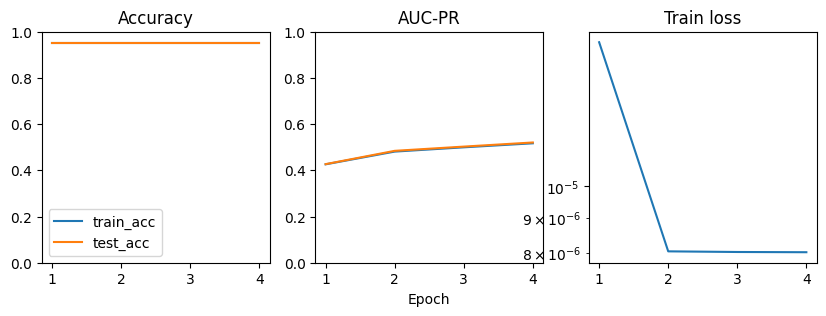

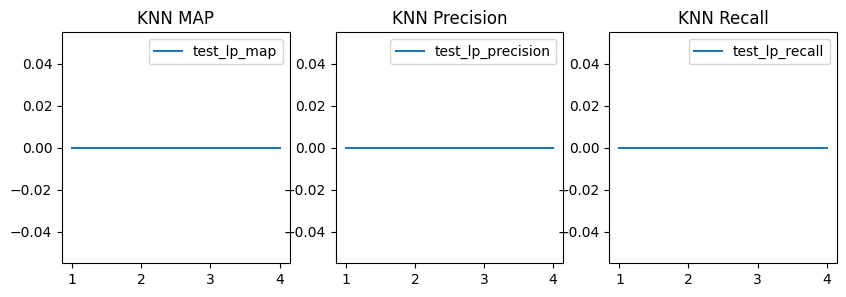

In [81]:
# Main script

print_config_vars()
# clear_cuda_mem()

print('Creating PyG graph...')
# data, mappings = create_pyg_graph()
display(data)

print(f"Number of nodes: {data['sotu'].x.shape[0]}")
print(f"Number of edges: {data['sotu', 'co_occur', 'sotu'].edge_index.shape[1]}")
print(f"Feature dimensions: {data['sotu'].x.shape}")


print('Splitting data...')
train_data, val_data, test_data, ref_data = split_data(data)
train_loader = get_train_loader(train_data)
val_loader = get_val_loader(val_data)
test_loader = get_val_loader(test_data)

# inv_mappings = {}
# for key, mapping in mappings.items():
#     inv_mappings[key] = {v: k for k, v in mapping.items()}

print('Training model...')
model = get_model_v1(ref_data)
stats = train_and_eval_loop(model, train_loader, val_loader, test_loader, ref_data)
plot_training_stats(stats)

# results, stats = run_top_k_lp_predictions(model, ref_data, mappings, k=5)
# print(stats)

# plot_predictions(results)

In [82]:
display(min(stats['train_loss']))
display(max(stats['test_acc']))
display(max(stats['test_auc_pr']))
display(stats['test_auc_pr'])
display(max(stats['train_auc_pr']))
print(max(stats['train_acc']))

8.02274627226277e-06

0.9523809523809523

0.5205109059914217

[0.4267381305076982,
 0.4843383898320306,
 0.5026585369927372,
 0.5205109059914217]

0.5169766856335459

0.9523809523809523


In [83]:
# Save or load model weights

def save_model(model):
    model_name = 'model_v3'
    weights_dir = f"{MODEL_DIR}/{model_name}"
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR, exist_ok=True)
    torch.save(model.state_dict(), weights_dir)

def load_model(model_name='model_v3'):
    model = get_model_v1(data)
    weights_dir = f"{MODEL_DIR}/{model_name}"
    model.load_state_dict(torch.load(weights_dir))
    return model

# model = load_model()
# save_model(model)

## UMAP + KNN Index

#### Setup

In [19]:
import umap
from umap.umap_ import nearest_neighbors
import seaborn as sns
import faiss

USE_FT_INDEX = False
USE_AVG_QUERY = False

In [20]:
# Helpers: get input xs

def get_xs(data, use_ft_index=USE_FT_INDEX):
    if use_ft_index:
        data = data.to('cpu')
        x = data['sotu'].x.numpy()
    else:
        data.to(device)
        if MODEL_CONFIG['USE_UNSUPERVISED_MODEL']:
            dst_emb = model(ref_data.x_dict,ref_data.edge_index_dict)[TRAINING_CONFIG['TARGET_EDGE'][2]]
            # dst_emb = dst_emb['sotu']
            # out = model.decode(z, data[TRAINING_CONFIG['TARGET_EDGE']].edge_label_index).view(-1).sigmoid()
        else:
            dst_emb = model.encoder(data.x_dict, data.edge_index_dict)['sotu']
        dst_emb = dst_emb.cpu()
        dst_emb = dst_emb.detach().numpy()
        x = dst_emb
    return x


def get_target_sotus(data, mappings, sotus):
    sotu_mapping = mappings['sotu']
    sotu_idx = [sotu_mapping[sotu] for sotu in sotus if sotu in sotu_mapping]
    sotu_fts = data['sotu'].x[sotu_idx].numpy()
    return sotu_fts, sotu_idx

In [21]:
# Helpers: KMeans clustering

def get_centroid_indicies(
        x,
        ncentroids=100,
        niter=20,
):
    d = x.shape[1]
    kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=True)
    kmeans.train(x)

    _, I = kmeans.index.search(x, 1)
    I_flat = [i[0] for i in I]
    return I_flat


#### Run umap

In [ ]:
kadipiro_sotus = [
    'u405395',
    'u197030',
    'u856827',
    'u651691',
    'u1033658',
    'u761925',
    'u713776',
    'u260497',
    'u715705',
    'u723959',
    'u653721',
    'u779238',
    'u813011',
    'u1059793',
    'u857672',
]

TRAINING_CONFIG['REMOVE_ISOLATED_NODES'] = False
data, mappings = create_pyg_graph()

data = data.to('cpu')

target_fts, target_idx = get_target_sotus(data, mappings, kadipiro_sotus)
# target_sotus = pd.read_csv(f'{DATA_DIR}/human_sotus.csv', index_col=False)['sotu']
# target_sotu_fts, target_sotu_idx = get_target_sotus(data, mappings, target_sotus)


# Get embeddings/features
x = get_xs(data)
print(x.shape)

A


/tmp/ipykernel_21048/1193406524.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sotu_x = torch.load(f'{FEATURES_DIR}/{feature_type}_level_{hierarchy_level}.pt')
/tmp/i

SOTU nodes: torch.Size([397578, 3269])
SOTU edges: torch.Size([2, 520046])
(397578, 128)


Running KMeans...
Sampling a subset of 128000 / 397578 for training
Clustering 128000 points in 128D to 500 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.03 s
  Iteration 19 (10.18 s, search 10.13 s): objective=1584.74 imbalance=1.267 nsplit=0       
397578
Running UMAP...


/home/ljp/miniconda3/envs/rnalab/lib/python3.12/site-packages/umap/umap_.py:2027: UserWarning: precomputed_knn has a lower number of neighbors than n_neighbors parameter. precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


UMAP(precomputed_knn=(array([[     0, 140811, 76443, ..., 140585, 198181, 176483],
       [     1, 64687, 54379, ..., 135318, 51412, 147425],
       [     2, 116541, 55969, ..., 183570, 18219, 83449],
       ...,
       [198786, 52168, 91894, ..., 140025, 183420, 67852],
       [198787, 71683, 108148, ..., 55883, 34013, 104649],
       [198788, 173090, 80817, ..., 20427, 145216, 93417]], dtype=int32), array([[0.        , 0.01277429, 0.01284904, ..., 0.01396661, 0.01428668,
        0.01444626],
       [0.        , 0.0087093 , 0.01038402, ..., 0.01134926, 0.01141261,
        0.01155689],
       [0.        , 0.01272604, 0.01327384, ..., 0.01505678, 0.01539333,
        0.01553915],
       ...,
       [0.        , 0.06119639, 0.06808166, ..., 0.07834613, 0.07972169,
        0.0847715 ],
       [0.        , 0.01698274, 0.01999173, ..., 0.02255156, 0.02259371,
        0.0226091 ],
       [0.        , 0.02140624, 0.021843  , ..., 0.02607477, 0.0272002 ,
        0.02744632]], dtype=float32), <p

Epochs completed:   3%| ▎          6/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  12%| █▎         25/200 [00:00]

	completed  20  /  200 epochs


Epochs completed:  22%| ██▎        45/200 [00:01]

	completed  40  /  200 epochs


Epochs completed:  32%| ███▎       65/200 [00:01]

	completed  60  /  200 epochs


Epochs completed:  42%| ████▎      85/200 [00:02]

	completed  80  /  200 epochs


Epochs completed:  52%| █████▎     105/200 [00:03]

	completed  100  /  200 epochs


Epochs completed:  62%| ██████▎    125/200 [00:03]

	completed  120  /  200 epochs


Epochs completed:  72%| ███████▎   145/200 [00:04]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▎  165/200 [00:04]

	completed  160  /  200 epochs


Epochs completed:  92%| █████████▎ 185/200 [00:05]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:05]


Sat Nov 30 20:34:45 2024 Finished embedding
Plotting...


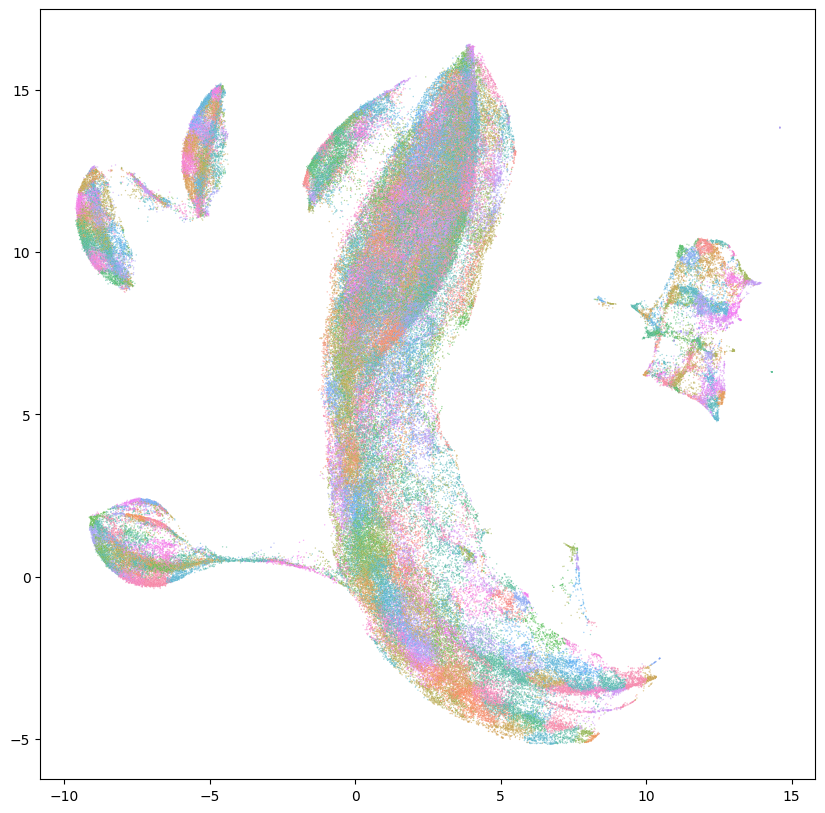

In [ ]:
# KMeans + UMAP 

# Kmeans clustering for coloring
print('Running KMeans...')
ncentroids = 500
I_flat = get_centroid_indicies(x, ncentroids=ncentroids)
print(len(I_flat))

# randomly sample half of the data
random_indices = np.random.choice(len(I_flat), int(len(I_flat) / 2), replace=False)
x = x[random_indices]
I_flat = [I_flat[i] for i in random_indices]

## UMAP
print('Running UMAP...')
metric = 'euclidean' # 'cosine', 'euclidean'
precomputed_knn = nearest_neighbors(
    x,
    n_neighbors = 10,
    metric=metric,
    metric_kwds=None,
    angular=False,
    random_state=1
)
umap_emb = umap.UMAP(
    precomputed_knn=precomputed_knn,
    verbose=True,
    metric=metric,
).fit_transform(x)
# # umap_emb = umap.UMAP(verbose=True).fit_transform(x)

print('Plotting...')
plt.figure(figsize=(10, 10))

#  color by kmeans
colors = sns.color_palette('husl', ncentroids)
sns.scatterplot(x=umap_emb.T[0], y=umap_emb.T[1], hue=I_flat, palette=colors, alpha=0.5, s=1)

# label centroids
# centroids = kmeans.centroids
# _, I_centroids = kmeans.index.search(centroids, 1)
# I_centroids_flat = [i[0] for i in I_centroids]
# inv_mapping = {v: k for k, v in mappings['sotu'].items()}
# centroid_sotus = [inv_mapping[i] for i in I_centroids_flat]
# labels = []
# for sotu in centroid_sotus:
#     # get_top_sotu_labels
#     tissue, host, biome, genbank = get_top_sotu_labels(sotu)
#     # str_labels = ', '.join(l[0] for l in sotu_labels if len(l) > 0)
#     str_labels = f'{
#         genbank[0] if len(genbank) > 0 else "N/A"
#     # }, {
#     #     host[0] if len(host) > 0 else "N/A"
#     }, {
#         tissue[0] if len(tissue) > 0 else "N/A"
#     }'
#     labels.append(str_labels)

# for i, txt in enumerate(labels):
#     plt.annotate(txt, (umap_emb[I_flat.index(I_centroids_flat[i])][0], umap_emb[I_flat.index(I_centroids_flat[i])][1]), fontsize=6, ha='center')


# color by sotu family
# sotu_family = pd.read_csv(f'{DATA_DIR}/palm_virome_sotu.csv', index_col=False)
# colors = sns.color_palette('husl', len(sotu_family['tax_family'].unique()))
# inv_mapping = {v: k for k, v in mappings['sotu'].items()}
# sotu_family.set_index('sotu', inplace=True)

# hue = [sotu_family[sotu_family['sotu'] == inv_mapping[i]]['tax_family'].values[0] for i in I_flat]
# color_mapping = {k: v for k, v in zip(sotu_family['tax_family'].unique(), colors)}
# color = [color_mapping[h] for h in hue]
# sns.scatterplot(x=umap_emb.T[0], y=umap_emb.T[1], hue=color, alpha=0.5, s=1)

## color target centroids
# target_indices = [mappings['sotu'][sotu] for sotu in target_sotus if sotu in mappings['sotu']]
# target_centroids = [
#     I_flat[idx].item()
#     for idx in target_indices
# ]
# sns.scatterplot(x=umap_emb.T[0][target_centroids], y=umap_emb.T[1][target_centroids], color='red', s=20)

plt.gca().get_legend().remove()
plt.show()
# plt.legend(bbox_to_anchor=(1,1), loc='upper left')

#### Debug kadipiro

In [148]:
# KNN Recommendations

d = x.shape[1]
k = 5
print(x.dtype)
index = faiss.IndexFlatL2(x.shape[1])
index.add(x)

kadipiro_query = x[target_idx]

D, I = index.search(kadipiro_query, k)
print(I.shape)
I_flat = I.flatten()
D_flat = D.flatten()
I_flat_with_dist = list(zip(I_flat, D_flat))

# get sotu from index using mappings
sotu_mapping = mappings['sotu']
inv_sotu_mapping = {v: k for k, v in sotu_mapping.items()}
knn_sotu_ids = [inv_sotu_mapping[i] for i in I_flat]

# get common and novel sotus in knn and query
knn_sotu_ids_set = set(knn_sotu_ids)
query_sotu_ids_set = set(kadipiro_sotus)

common_sotus = knn_sotu_ids_set.intersection(query_sotu_ids_set)
print(common_sotus)
novel_sotus = knn_sotu_ids_set.difference(query_sotu_ids_set)
print(novel_sotus)


# print distances for each novel sotu
sotu_to_distance = {inv_sotu_mapping[i]: d for i, d in I_flat_with_dist}
rows = []
for sotu in novel_sotus:
    rows.append({
        'sotu': sotu,
        'distance': sotu_to_distance[sotu]
    })

novel_sotu_df = pd.DataFrame(rows)
novel_sotu_df = novel_sotu_df.sort_values('distance')
sotu_info = pd.read_csv(f'{DATA_DIR}/palm_virome_sotu.csv', index_col=False)
novel_sotu_df = novel_sotu_df.merge(sotu_info, left_on='sotu', right_on='sotu')
novel_sotu_df = novel_sotu_df[['sotu', 'distance', 'tax_family', 'tax_species']]
print(novel_sotu_df)

print(novel_sotu_df['tax_species'].unique())



# Write the index to save on disk if needed
# faiss.write_index(index, f"./index/{index_name}.index")
# read_index()

novel_sotu_df.to_csv(f'{DATA_DIR}/kadipiro_recommendations.csv', index=False)

float32


IndexError: index 337030 is out of bounds for axis 0 with size 198789

In [ ]:
# MIPS Recommendations

x = data['sotu'].x
# move to cpu
x = x.cpu()

if USE_AVG_QUERY:
    kadipiro_query = kadipiro_query.mean(dim=0).unsqueeze(0)
else:
    kadipiro_query = x[target_idx]

mips = MIPSKNNIndex(x)
D, I = mips.search(kadipiro_query, k)

I_flat = I.flatten()
D_flat = D.flatten()
# convert tensor items to int
I_flat = [int(i) for i in I_flat]
D_flat = [float(d) for d in D_flat]

I_flat_with_dist = list(zip(I_flat, D_flat))

# get sotu from index using mappings

knn_sotu_ids = [inv_sotu_mapping[i] for i in I_flat]

# get common and novel sotus in knn and query
knn_sotu_ids_set = set(knn_sotu_ids)
query_sotu_ids_set = set(kadipiro_sotus)

common_sotus = knn_sotu_ids_set.intersection(query_sotu_ids_set)
print(common_sotus)
novel_sotus = knn_sotu_ids_set.difference(query_sotu_ids_set)
print(novel_sotus)


# print distances for each novel sotu
sotu_to_distance = {inv_sotu_mapping[int(i)]: d for i, d in I_flat_with_dist}
rows = []
for sotu in novel_sotus:
    rows.append({
        'sotu': sotu,
        'distance': sotu_to_distance[sotu]
    })

novel_sotu_df = pd.DataFrame(rows)
novel_sotu_df = novel_sotu_df.sort_values('distance')

novel_sotu_df = novel_sotu_df.merge(sotu_info, left_on='sotu', right_on='sotu')
novel_sotu_df = novel_sotu_df[['sotu', 'distance', 'tax_family', 'tax_species']]
print(novel_sotu_df)

print(novel_sotu_df['tax_species'].unique())

novel_sotu_df.to_csv(f'{DATA_DIR}/kadipiro_recommendations_mips.csv', index=False)


## Leiden communities

In [3]:
from graphdatascience import GraphDataScience


PROJECTION_NAME = 'virome-embeddings'
DATA_DIR = '../../../../data'
FEATURES_DIR = f'{DATA_DIR}/features'


/home/ljp/miniconda3/envs/rnalab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def get_gds_client():
    return GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def query_gds(query):
    client = get_gds_client()
    return client.run_cypher(query)

In [5]:
# make edges undirected
# add weight property to edges
def get_projection(projection_name):
    gds = get_gds_client()
    default_weight_params = {'properties': { 'weight': { 'property': '*', 'aggregation': 'COUNT' } } } 
    projection = gds.graph.project(
        graph_name=projection_name,
        node_spec=['*'],
        relationship_spec={
            'HAS_BIOPROJECT': { 'orientation': 'UNDIRECTED', **default_weight_params },
            'HAS_DISEASE_METADATA': { 'orientation': 'UNDIRECTED',  **default_weight_params },
            'HAS_HOST_METADATA': { 'orientation': 'UNDIRECTED',  **default_weight_params },
            'HAS_HOST_STAT': { 'orientation': 'UNDIRECTED', 'properties': { 'weight': { 'property': 'percentIdentity' } } },
            'HAS_INFERRED_TAXON': { 'orientation': 'UNDIRECTED',  'properties': { 'weight': { 'property': 'percentIdentity' } } },
            # 'HAS_PALMPRINT': { 'orientation': 'UNDIRECTED' },
            'HAS_PARENT': { 'orientation': 'UNDIRECTED',  **default_weight_params },
            'HAS_SOTU': { 'orientation': 'UNDIRECTED',  **default_weight_params },
            'HAS_TISSUE_METADATA': { 'orientation': 'UNDIRECTED',  **default_weight_params },
            'SEQUENCE_ALIGNMENT': { 'orientation': 'UNDIRECTED', 'properties': { 'weight': { 'property': 'percentIdentity' } } },
        }
    )
    return projection

def delete_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        gds.graph.drop(gds.graph.get(projection_name))

# At least one common node property is needed to use the gds node export function
def add_degree_property(gds, projection_name):
    df_degree = gds.degree.mutate(
        G=gds.graph.get(projection_name),
        mutateProperty='degree',
        nodeLabels=["*"],
        relationshipTypes=["*"],
    )
    return df_degree

gds = get_gds_client()

if gds.graph.exists(PROJECTION_NAME)['exists']:
    gds.graph.drop(gds.graph.get(PROJECTION_NAME))

projection = get_projection(PROJECTION_NAME)
add_degree_property(gds, PROJECTION_NAME)

display(projection)

GraphCreateResult(graph=Graph({'graphName': 'virome-embeddings', 'nodeCount': 11470114, 'relationshipCount': 159286083, 'database': 'neo4j', 'configuration': {'relationshipProjection': {'HAS_PARENT': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'weight': {'aggregation': 'COUNT', 'property': '*', 'defaultValue': None}}, 'type': 'HAS_PARENT'}, 'HAS_DISEASE_METADATA': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'weight': {'aggregation': 'COUNT', 'property': '*', 'defaultValue': None}}, 'type': 'HAS_DISEASE_METADATA'}, 'HAS_TISSUE_METADATA': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'weight': {'aggregation': 'COUNT', 'property': '*', 'defaultValue': None}}, 'type': 'HAS_TISSUE_METADATA'}, 'SEQUENCE_ALIGNMENT': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'weight': {'aggregation': 'DEFAULT', 'p

In [6]:
def get_wcc_communities(graph, seed_property=None, edge_weight_property=None):
    communities = gds.wcc.stream(
        graph,
        relationshipWeightProperty=edge_weight_property,
        seedProperty=seed_property,
    )
    return communities


def get_leiden_communities(graph, seed_property=None, edge_weight_property=None, max_levels=10):
    communities = gds.leiden.stream(
        graph,
        relationshipWeightProperty=edge_weight_property,
        seedProperty=seed_property,
        minCommunitySize=1,
        maxLevels=max_levels,
        includeIntermediateCommunities=True,
        consecutiveIds=False,
        gamma=5.0, # Default: 1.0, Resolution parameter for modularity, higher -> more communities
        theta=0.01, # Default: 0.01, Randomness when breaking communities
        tolerance=0.0001, # Default: 0.0001, Min change in modularity between iterations
    )
    return communities


projection = gds.graph.get(PROJECTION_NAME)
# communities = get_wcc_communities(projection, edge_weight_property='weight')
communities = get_leiden_communities(projection, edge_weight_property='weight')

if 'componentId' in communities.columns:
    communities['communityId'] = communities['componentId']

# denormalize communities using values.communityIds for multi-community nodes
if 'values' in communities.columns:
    communities['values'] = communities['values'].apply(lambda x: x['communityIds'])
    communities = communities.explode('values')
    communities['communityId'] = communities['values']
    communities = communities.drop(columns=['values'])

print('Number of communities:')
print(communities['communityId'].nunique())

print('Community sizes distribution:')
print(communities['communityId'].value_counts().describe())

print('Singletons:')
print(communities['communityId'].value_counts().loc[communities['communityId'].value_counts() == 1].count())

print('Largest community:')
print(communities['communityId'].value_counts().max())

print('top 10 communities:')
print(communities['communityId'].value_counts().head(10))

Number of communities:
36715
Community sizes distribution:
count    3.671500e+04
mean     3.124095e+02
std      1.184895e+04
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.325238e+06
Name: count, dtype: float64
Singletons:
26055
Largest community:
1325238
top 10 communities:
communityId
18115    1325238
29150    1248344
33048     947959
10628     525575
8455      321886
12064     292271
33160     252382
33032     212800
29450     195078
20684     188323
Name: count, dtype: int64


In [7]:
# print(communities)
print(communities['communityId'].value_counts())
print(communities)

communityId
18115    1325238
29150    1248344
33048     947959
10628     525575
8455      321886
          ...   
7604           1
7603           1
7602           1
7601           1
31705          1
Name: count, Length: 36715, dtype: int64
            nodeId  communityId  \
0           163860         3073   
1           163861        29150   
2           163862         3073   
3           163863         3073   
4           163864         3073   
...            ...          ...   
11470109  11470109        32935   
11470110  11470110        31704   
11470111  11470111        29150   
11470112  11470112        31705   
11470113  11470113         3073   

                                intermediateCommunityIds  
0                  [11399115, 3828, 131, 51, 3277, 3073]  
1            [11274352, 42996, 26287, 2442, 3053, 29150]  
2                  [11399115, 3828, 131, 51, 3277, 3073]  
3                  [11399115, 3828, 131, 51, 3277, 3073]  
4                  [11399115, 3828, 131, 51,

In [8]:
def get_sra_node_mapping():
    if os.path.exists(f'{DATA_DIR}/sra_node_mapping.csv'):
        return pd.read_csv(f'{DATA_DIR}/sra_node_mapping.csv')
    query = """
        MATCH (n:SRA)
        RETURN n.runId as runId, id(n) as nodeId
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/sra_node_mapping.csv', index=False)
    return df

run_node_mapping = get_sra_node_mapping()
run_node_mapping = run_node_mapping.set_index('nodeId')

selected_community = communities.copy()
target_level = -1
selected_community['communityId'] = communities['intermediateCommunityIds'].apply(lambda x: x[target_level])
selected_community = selected_community[['nodeId', 'communityId']]


run_to_community_df = run_node_mapping.merge(selected_community, left_on='nodeId', right_on='nodeId', how='left')
run_to_community_df = run_to_community_df[['runId', 'communityId']]
run_to_community_df = run_to_community_df.rename(columns={'communityId': 'community_id', 'runId': 'run'})
print(run_to_community_df)

# drop communities with only 1 member
community_counts = run_to_community_df['community_id'].value_counts()
single_communities = community_counts[community_counts == 1].index
run_to_community_df = run_to_community_df[~run_to_community_df['community_id'].isin(single_communities)]

print(run_to_community_df['community_id'].nunique())
print(run_to_community_df['community_id'].value_counts().describe())

run_to_community_df.to_csv(f'{DATA_DIR}/run_to_community.csv', index=False)


                 run  community_id
0        SRR14663995         32935
1        SRR14663996         18115
2        SRR14663997         18115
3        SRR14663998         18115
4        SRR14663999         18115
...              ...           ...
7680421  SRR14663990         32935
7680422  SRR14663991         32935
7680423  SRR14663992         32935
7680424  SRR14663993         32935
7680425  SRR14663994         32935

[7680426 rows x 2 columns]
1175
count    1.175000e+03
mean     6.536256e+03
std      6.375619e+04
min      2.000000e+00
25%      4.000000e+00
50%      1.500000e+01
75%      6.100000e+01
max      1.299064e+06
Name: count, dtype: float64


## Write community IDs to db

In [9]:
import psycopg2
import faiss

### Create run to community df and csv using kmeans clusters 

In [22]:
# create dataframe of sotu to community label

def get_sotu_to_community():
    xs = get_xs(data)

    ncentroids = 1000
    I_flat = get_centroid_indicies(xs, ncentroids=ncentroids)

    sotu_mapping = mappings['sotu']
    inv_sotu_mapping = {v: k for k, v in sotu_mapping.items()}
    sotu_to_community = {inv_sotu_mapping[i]: c for i, c in zip(range(len(I_flat)), I_flat)}

    sotu_community_df = pd.DataFrame(list(sotu_to_community.items()), columns=['sotu', 'community'])
    # sotu_community_df.to_csv(f'{DATA_DIR}/sotu_community.csv', index=False)
    return sotu_community_df

sotu_community_df = get_sotu_to_community()
print(sotu_community_df)

NameError: name 'data' is not defined

In [18]:
# plot distribution of communities 
plt.figure(figsize=(16, 6))
community_counts = sotu_community_df.groupby('community').count().reset_index()
community_counts = community_counts.sort_values('sotu', ascending=False)
sns.barplot(x='community', y='sotu', data=community_counts)
plt.xticks(rotation=90)
plt.show()


NameError: name 'sotu_community_df' is not defined

<Figure size 1600x600 with 0 Axes>

In [13]:
# create dataframe of sotu to runId 

def get_logan_read_connection():
    return psycopg2.connect(
        host=os.environ.get('PG_HOST'),
        database=os.environ.get('PG_DATABASE_LOGAN'),
        user=os.environ.get('PG_USER_LOGAN'),
        password=os.environ.get('PG_PASSWORD_LOGAN'),
        port=os.environ.get('PG_PORT'))

def get_sotu_to_run():
    if os.path.exists(f'{DATA_DIR}/sotu_to_run.csv'):
        return pd.read_csv(f'{DATA_DIR}/sotu_to_run.csv')
    conn = get_logan_read_connection()
    cur = conn.cursor()
    cur.execute('SELECT DISTINCT sotu, run as run FROM palm_virome')
    rows = cur.fetchall()
    sotu_to_run = pd.DataFrame(rows, columns=['sotu', 'run'])
    sotu_to_run.to_csv(f'{DATA_DIR}/sotu_to_run.csv', index=False)
    return sotu_to_run

sotu_to_run_df = get_sotu_to_run()

In [46]:
# create dataframe of runId to community label

def get_run_to_community(sotu_community_df, sotu_to_run_df):
    merged_df = sotu_to_run_df.merge(sotu_community_df, on='sotu', how='inner')
    run_to_community_df = merged_df[['run', 'community']]
    run_to_community_df = run_to_community_df.drop_duplicates()
    run_to_community_df.to_csv(f'{DATA_DIR}/run_to_community.csv', index=False)
    return run_to_community_df


run_to_community_df = get_run_to_community(sotu_community_df, sotu_to_run_df)
print(run_to_community_df)

                 run  community
0          DRR297576        677
1         ERR7672908        677
2         ERR1352904        347
3        SRR14039584        949
4        SRR18186926        949
...              ...        ...
3415652  SRR14039656        195
3415653  SRR14039657        195
3415654  SRR14039658        195
3415660    DRR297853        740
3415661   SRR9077587        873

[2352749 rows x 2 columns]


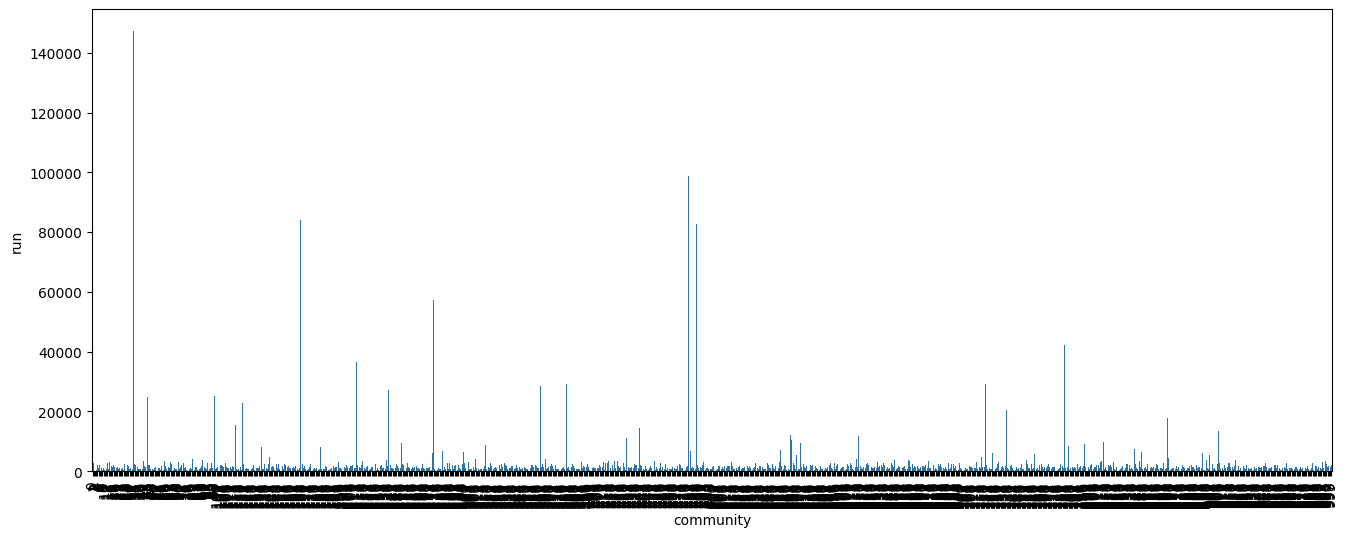

In [47]:
# plot distribution of communities 
plt.figure(figsize=(16, 6))
community_counts = run_to_community_df.groupby('community').count().reset_index()
community_counts = community_counts.sort_values('run', ascending=False)
sns.barplot(x='community', y='run', data=community_counts)
plt.xticks(rotation=90)
plt.show()

### Write csv to psql

In [10]:
def get_logan_write_connection():
    return psycopg2.connect(
        database=os.environ.get('PG_DATABASE_LOGAN'),
        host=os.environ.get('PG_HOST'),
        user=os.environ.get('PG_WRITE_USER'),
        password=os.environ.get('PG_WRITE_PASSWORD'),
        port="5432")

def write_run_community_labels():
    conn = get_logan_write_connection()
    cursor = conn.cursor()

    cursor.execute('DROP TABLE IF EXISTS public.virome_community CASCADE')
    cursor.execute('''
        CREATE TABLE public.virome_community (
            run VARCHAR,
            community_id VARCHAR,
            PRIMARY KEY (run, community_id)
        )
    ''')
    conn.commit()

    filename = f"{DATA_DIR}/run_to_community.csv"
    
    copy_sql = """
        COPY public.virome_community (run, community_id)
        FROM stdin WITH CSV HEADER
        DELIMITER as ','
    """
    with open(filename, 'r') as f:
        try:
            cursor.copy_expert(sql=copy_sql, file=f)
            conn.commit()
        except Exception as error:
            print("Error: %s" % error)
            conn.rollback()
            cursor.close()
            return error

    cursor.execute('''
        CREATE INDEX virome_community_run_idx
        ON public.virome_community (run)
    ''')
    conn.commit()

    cursor.execute('''
        CREATE INDEX virome_community_id_idx
        ON public.virome_community (community_id)
    ''')
    conn.commit()

    cursor.execute('''
        GRANT SELECT ON public.virome_community TO public_reader
    ''')
    conn.commit()

    cursor.execute('''
        GRANT SELECT ON public.virome_community TO open_virome
    ''')
    conn.commit()

    cursor.execute('''
        DROP MATERIALIZED VIEW IF EXISTS public.ov_counts_virome_community
    ''')

    cursor.execute('''
        CREATE MATERIALIZED VIEW public.ov_counts_virome_community AS
        SELECT 
            a.name, COUNT(*) as count, ov.has_virus AS virus_only
        FROM  (
                   SELECT run as acc, community_id as name
                   FROM public.virome_community
            ) as a
            JOIN (
                    SELECT ov_identifiers.run_id AS acc, 
                    ov_identifiers.has_virus
                    FROM ov_identifiers
            ) as ov 
            ON a.acc = ov.acc
        GROUP BY a.name, ov.has_virus
        ORDER BY (count(*)) DESC
        WITH DATA
    ''')
    conn.commit()

    cursor.execute('''
        GRANT SELECT ON public.ov_counts_virome_community TO public_reader
    ''')
    conn.commit()

    cursor.execute('''
        GRANT SELECT ON public.ov_counts_virome_community TO open_virome
    ''')
    conn.commit()

    conn.close()
    return True

write_run_community_labels()

True

## Validate Recommendations (Kadipiro - Arbovirus)

In [ ]:
import os
import sys

from neo4j import GraphDatabase

class Neo4jConnection:
    def __init__(self, uri, user, pwd):
        self._uri = uri
        self._user = user
        self._pwd = pwd
        self._driver = None
        try:
            self._driver = GraphDatabase.driver(
                self._uri, auth=(self._user, self._pwd))
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):
        if self._driver is not None:
            self._driver.close()

    def query(self, query, parameters=None, db=None):
        assert self._driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            session = self._driver.session(
                database=db) if db is not None else self._driver.session()
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response


def get_connection():
    return Neo4jConnection(
        uri=os.environ.get('NEO4J_URI'),
        user=os.environ.get('NEO4J_USER'),
        pwd=os.environ.get('NEO4J_PASSWORD')
    )

def query_neo4j(query):
    conn = get_connection()
    response = conn.query(query)
    conn.close()
    rows = []
    for result in response:
        rows.append(result.data())
    df = pd.DataFrame(rows)
    return df


In [ ]:
nb_stdout = sys.stdout

In [ ]:
old_stdout = nb_stdout
pd.set_option('display.width', 1000)

log_file = open(f'{DATA_DIR}/recommendation_validation.md', 'w')

sys.stdout = log_file

top_k = 20

print(f'## Recommendations for Kadipiro sotus (top {top_k})')
print()

recommended = pd.read_csv(f'{DATA_DIR}/kadipiro_recommendations.csv')

# add ranking based on distance
recommended = recommended.sort_values('distance')
recommended['rank'] = range(1, len(recommended) + 1)

recommended = recommended.head(top_k)
recommended_sotus = recommended['sotu'].values

print(f"### Top {top_k} recommendations")
print()
print(recommended)
print()

# q1: use sotu id to get arthropoda counts for kmers and metadata labels
q1 = f'''
    MATCH (n:SOTU)<-[:HAS_SOTU]-(s:SRA)-[r1:HAS_HOST_STAT]->(t_stat:Taxon)
    WHERE n.sotu in [{','.join([f"'{sotu}'" for sotu in recommended_sotus])}]
    AND (t_stat.taxPhylum = 'Arthropoda')
    WITH n, max(r1.percentIdentity) as maxKmerPerc
    OPTIONAL MATCH (n:SOTU)<-[:HAS_SOTU]-(s:SRA)-[r2:HAS_HOST_METADATA]->(t_label:Taxon)
    WHERE n.sotu in [{','.join([f"'{sotu}'" for sotu in recommended_sotus])}]
    AND t_label.taxPhylum = 'Arthropoda'
    RETURN n.sotu as sotu, maxKmerPerc, COUNT(r2) as runLabelMatches
'''
# q2: sotu id for human counts
q2 = f'''
    MATCH (n:SOTU)<-[:HAS_SOTU]-(s:SRA)-[r1:HAS_HOST_STAT]->(t_stat:Taxon)
    WHERE n.sotu in [{','.join([f"'{sotu}'" for sotu in recommended_sotus])}]
    AND (t_stat.taxOrder = 'Primates')
    WITH n, max(r1.percentIdentity) as maxKmerPerc
    OPTIONAL MATCH (n:SOTU)<-[:HAS_SOTU]-(s:SRA)-[r2:HAS_HOST_METADATA]->(t_label:Taxon)
    WHERE n.sotu in [{','.join([f"'{sotu}'" for sotu in recommended_sotus])}]
    AND t_label.taxOrder = 'Primates'
    RETURN n.sotu as sotu, maxKmerPerc, COUNT(r2) as runLabelMatches
'''
# q3: use gb top hit for arthropoda counts
q3 = f'''
    MATCH (n:SOTU)-[:HAS_INFERRED_TAXON]->(t_virus:Taxon)
    WHERE n.sotu in [{','.join([f"'{sotu}'" for sotu in recommended_sotus])}]
    WITH n, t_virus 
    MATCH (t_virus)<-[r3:HAS_INFERRED_TAXON]-(:SOTU)<-[:HAS_SOTU]-(s:SRA)-[r1:HAS_HOST_STAT]->(t_stat:Taxon)
    WHERE (t_stat.taxPhylum = 'Arthropoda')
    AND r3.percentIdentity > 75
    WITH n, t_virus, max(r1.percentIdentity) as maxKmerPerc
    OPTIONAL MATCH (n:SOTU)<-[:HAS_SOTU]-(s:SRA)-[r2:HAS_HOST_METADATA]->(t_label:Taxon)
    WHERE n.sotu in [{','.join([f"'{sotu}'" for sotu in recommended_sotus])}]
    AND t_label.taxPhylum = 'Arthropoda'
    RETURN n.sotu as sotu, maxKmerPerc, COUNT(r2) as runLabelMatches, t_virus.taxSpecies as topGbHit, 70 as gbPidThreshold
'''

# q4: gb top hit for human counts
q4 = f'''
    MATCH (n:SOTU)-[:HAS_INFERRED_TAXON]->(t_virus:Taxon)
    WHERE n.sotu in [{','.join([f"'{sotu}'" for sotu in recommended_sotus])}]
    WITH n, t_virus 
    MATCH (t_virus)<-[r3:HAS_INFERRED_TAXON]-(:SOTU)<-[:HAS_SOTU]-(s:SRA)-[r1:HAS_HOST_STAT]->(t_stat:Taxon)
    WHERE (t_stat.taxOrder = 'Primates')
    AND r3.percentIdentity > 75
    WITH n, t_virus, max(r1.percentIdentity) as maxKmerPerc
    OPTIONAL MATCH (n:SOTU)<-[:HAS_SOTU]-(s:SRA)-[r2:HAS_HOST_METADATA]->(t_label:Taxon)
    WHERE n.sotu in [{','.join([f"'{sotu}'" for sotu in recommended_sotus])}]
    AND t_label.taxOrder = 'Primates'
    RETURN n.sotu as sotu, maxKmerPerc, COUNT(r2) as runLabelMatches, t_virus.taxSpecies as topGbHit, 70 as gbPidThreshold
'''

for qs in [('sOTU id', q1, q2), ('Top GenBank hit', q3, q4)]:
    print()
    print(f'### Using **{qs[0]}** to validate')
    print()

    arthropoda_df = query_neo4j(qs[1])
    human_df = query_neo4j(qs[2])

    final_df = pd.merge(
        arthropoda_df,
        human_df,
        on='sotu',
        how='outer',
        suffixes=('_arthropoda', '_human')
    )
    final_df = final_df.merge(recommended, on='sotu')

    print(f'#### Kmer matches in both arthropoda and human')
    kmer_matches = final_df.dropna(subset=['maxKmerPerc_arthropoda', 'maxKmerPerc_human'])
    kmer_matches['avgKmerPerc'] = (kmer_matches['maxKmerPerc_arthropoda'] + kmer_matches['maxKmerPerc_human']) / 2
    kmer_matches = kmer_matches.sort_values('avgKmerPerc', ascending=False)
    kmer_matches = kmer_matches.drop(columns=['avgKmerPerc'])
    kmer_matches = kmer_matches[['sotu', 'distance', 'rank', 'tax_species', 'maxKmerPerc_arthropoda',  'maxKmerPerc_human']]

    print(kmer_matches)
    print()

    print(f'### Run label matches in both arthropoda and human')
    run_label_matches = final_df.dropna(subset=['runLabelMatches_arthropoda', 'runLabelMatches_human'])
    run_label_matches = run_label_matches[
        (run_label_matches['runLabelMatches_arthropoda'] > 0) & (run_label_matches['runLabelMatches_human'] > 0)
    ]
    run_label_matches['avgRunLabelMatches'] = (run_label_matches['runLabelMatches_arthropoda'] + run_label_matches['runLabelMatches_human']) / 2
    run_label_matches = run_label_matches.sort_values('avgRunLabelMatches', ascending=False)
    run_label_matches = run_label_matches.drop(columns=['avgRunLabelMatches'])
    run_label_matches = run_label_matches[['sotu', 'distance', 'rank', 'tax_species', 'runLabelMatches_arthropoda', 'runLabelMatches_human']]
    print(run_label_matches)
    print()


# Flaviviridae, Togaviridae, Reoviridae, Phenuiviridae, Rhabdoviridae, Asfarviridae, and Bunyaviridae
# Yellow fever virus: Flaviviridae
# West Nile virus: Flaviviridae
# Tick-borne encephalitis virus: Flaviviridae
# Dengue virus: Flaviviridae
# Zika virus: Flaviviridae
# Japanese encephalitis virus: Flaviviridae
# Rift Valley fever virus: Phenuiviridae


sys.stdout = old_stdout
pd.set_option('display.width', 80)
log_file.close()

## GraphRAG community summaries

### Setup

In [ ]:
import json
import re
from concurrent.futures import (
    ProcessPoolExecutor,
    as_completed,
)

from neo4j import GraphDatabase
from openai import AzureOpenAI
from json_repair import repair_json

In [12]:
DATA_DIR = '../../../../data'
FEATURES_DIR = f'{DATA_DIR}/features'

In [13]:
# OpenAI LLM helpers

def get_oai_client():
    return AzureOpenAI(
        azure_endpoint=os.getenv("OPENAI_ENDPOINT_GPT4_MINI"),
        api_key= os.getenv("OPENAI_TOKEN"),
        api_version="2024-09-01-preview"
    )

def get_llm_response(conversation):
    oai_client = get_oai_client()
    response = oai_client.chat.completions.create(
        # gpt-4o-mini
        model='gpt-4o-mini',
        messages=conversation,
    )
    return response.choices[0].message.content


def try_parse_json_object(input: str) -> tuple[str, dict]:
    """JSON cleaning and formatting utilities."""
    # Sometimes, the LLM returns a json string with some extra description, this function will clean it up.

    result = None
    try:
        # Try parse first
        result = json.loads(input)
    except json.JSONDecodeError:
        print("Warning: Error decoding faulty json, attempting repair")

    if result:
        return input, result

    _pattern = r"\{(.*)\}"
    _match = re.search(_pattern, input, re.DOTALL)
    input = "{" + _match.group(1) + "}" if _match else input

    # Clean up json string.
    input = (
        input.replace("{{", "{")
        .replace("}}", "}")
        .replace('"[{', "[{")
        .replace('}]"', "}]")
        .replace("\\", " ")
        .replace("\\n", " ")
        .replace("\n", " ")
        .replace("\r", "")
        .strip()
    )

    # Remove JSON Markdown Frame
    if input.startswith("```json"):
        input = input[len("```json") :]
    if input.endswith("```"):
        input = input[: len(input) - len("```")]

    try:
        result = json.loads(input)
    except json.JSONDecodeError:
        # Fixup potentially malformed json string using json_repair.
        input = str(repair_json(json_str=input, return_objects=False))

        # Generate JSON-string output using best-attempt prompting & parsing techniques.
        try:
            result = json.loads(input)
        except json.JSONDecodeError:
            print(f"error loading json, json={input}")
            return input, {}
        else:
            if not isinstance(result, dict):
                print(f"not expected dict type. type={type(result)}")
                return input, {}
            return input, result
    else:
        return input, result

In [14]:
# Neo4j helpers

class Neo4jConnection:
    def __init__(self, uri, user, pwd):
        self._uri = uri
        self._user = user
        self._pwd = pwd
        self._driver = None
        try:
            self._driver = GraphDatabase.driver(
                self._uri, auth=(self._user, self._pwd))
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):
        if self._driver is not None:
            self._driver.close()

    def query(self, query, parameters=None, db=None):
        assert self._driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            session = self._driver.session(
                database=db) if db is not None else self._driver.session()
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

def get_connection():
    return Neo4jConnection(
        uri=os.environ.get('NEO4J_URI'),
        user=os.environ.get('NEO4J_USER'),
        pwd=os.environ.get('NEO4J_PASSWORD')
    )

def serailize_records(records):
    rows = []
    for record in records:
        row = record.data()
        rows.append(row)
    return rows


### Get Community Summaries

In [17]:
# only keep runs in palm_virome, knowledge graph has additional unvalidated sOTUs and runs

def get_logan_read_connection():
    return psycopg2.connect(
        host=os.environ.get('PG_HOST'),
        database=os.environ.get('PG_DATABASE_LOGAN'),
        user=os.environ.get('PG_USER_LOGAN'),
        password=os.environ.get('PG_PASSWORD_LOGAN'),
        port=os.environ.get('PG_PORT'))

def get_sotu_to_run():
    if os.path.exists(f'{DATA_DIR}/sotu_to_run.csv'):
        return pd.read_csv(f'{DATA_DIR}/sotu_to_run.csv')
    conn = get_logan_read_connection()
    cur = conn.cursor()
    cur.execute('SELECT DISTINCT sotu, run as run FROM palm_virome')
    rows = cur.fetchall()
    sotu_to_run = pd.DataFrame(rows, columns=['sotu', 'run'])
    sotu_to_run.to_csv(f'{DATA_DIR}/sotu_to_run.csv', index=False)
    return sotu_to_run

palm_virome_runs = get_sotu_to_run()
run_to_community_df = pd.read_csv(f'{DATA_DIR}/run_to_community.csv')
run_to_community_df.set_index('run', inplace=True)

run_to_community_df = run_to_community_df[run_to_community_df.index.isin(palm_virome_runs['run'])]
print(run_to_community_df['community_id'].nunique())

938


In [18]:
run_to_community_df['community_id'].value_counts().index.unique()

Index([12064, 33032, 33048, 10726, 20684, 33261,  3073, 10715, 18115, 10735,
       ...
       33705, 34534, 10595, 10667, 33029, 34312, 34144, 19824, 23657, 33340],
      dtype='int64', name='community_id', length=938)

In [ ]:

conn = get_connection()

def get_sra_data(conn, run_str):
    query = f'''
        MATCH (run:SRA)-[:HAS_BIOPROJECT]->(bioproject:BioProject)
        WHERE run.runId in [{run_str}]
        RETURN
            COLLECT(DISTINCT run.bioSampleTitle) as bioSampleTitles,
            COLLECT(DISTINCT run.bioSampleGeoAttributeValues) as geoAttributeValues,
            COLLECT(DISTINCT run.bioSampleGeoBiomeName) as geoBiomeNames,
            COLLECT(DISTINCT bioproject.bioProject) as bioproject,
            COLLECT(DISTINCT bioproject.title) as bioProjectTitles,
            COLLECT(DISTINCT bioproject.description) as bioProjectDescriptions
    '''
    response = conn.query(query)
    return response[0]

def get_stat_host_counts(conn, run_str):
    query = f'''
        MATCH (run:SRA)-[:HAS_HOST_STAT]->(host_stat:Taxon)
        WHERE run.runId in [{run_str}]
        RETURN host_stat.taxOrder as statOrganism, COUNT(run) as count
        LIMIT 10
    '''
    response = conn.query(query)
    response = serailize_records(response)
    return response

def get_host_label_counts(conn, run_str):
    query = f'''
        MATCH (run:SRA)-[:HAS_HOST_METADATA]->(host_label:Taxon)
        WHERE run.runId in [{run_str}]
        RETURN 
            CASE host_label.rank
                    WHEN 'species' THEN host_label.taxSpecies 
                    WHEN 'genus' THEN host_label.taxGenus
                    WHEN 'family' THEN host_label.taxFamily
                    WHEN 'order' THEN host_label.taxOrder
                    WHEN 'phylum' THEN host_label.taxPhylum
                    WHEN 'kingdom' THEN host_label.taxKingdom
                    ELSE 'N/A'
            END as label, COUNT(run) as count
        LIMIT 10
    '''
    response = conn.query(query)
    response = serailize_records(response)
    return response

def get_disease_counts(conn, run_str):
    query = f'''
        MATCH (run:SRA)-[:HAS_DISEASE_METADATA]->(disease:Disease)
        WHERE run.runId in [{run_str}]
        RETURN disease.name as disease, COUNT(run) as count
        LIMIT 10
    '''
    response = conn.query(query)
    response = serailize_records(response)
    return response

def get_tissue_counts(conn, run_str):
    query = f'''
        MATCH (run:SRA)-[:HAS_TISSUE_METADATA]->(tissue:Tissue)
        WHERE run.runId in [{run_str}]
        RETURN tissue.scientificName as tissue, COUNT(run) as count
        LIMIT 10
    '''
    response = conn.query(query)
    response = serailize_records(response)
    return response

def get_sotu_species_counts(conn, run_str):
    query = f'''
        MATCH (run:SRA)-[:HAS_SOTU]->(sotu:SOTU)
        WHERE run.runId in [{run_str}]
        RETURN sotu.taxSpecies as species, COUNT(run) as count
        LIMIT 10
    '''
    response = conn.query(query)
    response = serailize_records(response)
    return response

def get_sotu_family_counts(conn, run_str):
    query = f'''
        MATCH (run:SRA)-[:HAS_SOTU]->(sotu:SOTU)
        WHERE run.runId in [{run_str}]
        RETURN sotu.taxFamily as family, COUNT(run) as count
        LIMIT 10
    '''
    response = conn.query(query)
    response = serailize_records(response)
    return response

def get_bioproject_summary(bioProjectIds, bioProjectTitles, bioProjectDescriptions):
    conversation = []

    instructions_prompt = '''
        ---Role---
        
        You are a helpful bioinformatics research assistant agent being used to summarize datasets in order to retain maximal information.

        ---Goal---
        
        Follow the instructions to summarize BioProjects:
        1. Provide a succinct overview of the high-level ideas covered by the bioproject titles, names, and descriptions, no longer than a paragraph.
        2. For each overarching topic in the summarization, cite all relevant bioproject ID(s).
        3. DO NOT reference any bioprojects that aren't given in the list.
        4. ONLY use the information provided in the bioprojects to generate the summary.
        5. Avoid using any external information or knowledge.
    '''
    bioproject_merged = list(zip(bioProjectIds, bioProjectTitles, bioProjectDescriptions))
    max_len = 10000
    bioprojects_prompt = ''
    for bioproject in bioproject_merged:
        bioprojects_prompt += f'''
            **{bioproject[0]}**: {bioproject[1]} - {bioproject[2]} \n
        '''
        if len(bioprojects_prompt) > max_len:
            bioprojects_prompt = ''
            break
    if len(bioprojects_prompt) == 0:
        for bioproject in bioproject_merged:
            bioprojects_prompt += f'''
                **{bioproject[0]}**: {bioproject[1]}  \n
            '''
            if len(bioprojects_prompt) > max_len:
                break
        
    conversation.append({
        "role": "system",
        "content": instructions_prompt
    })
    conversation.append({
        "role": "user",
        "content": bioprojects_prompt
    })
    response = get_llm_response(conversation)

    return response

def get_community_summary_prompt(run_str):
    conn = get_connection()
    sra_data = get_sra_data(conn, run_str)
    stat_host_counts = get_stat_host_counts(conn, run_str)
    host_label_counts = get_host_label_counts(conn, run_str)
    disease_counts = get_disease_counts(conn, run_str)
    tissue_counts = get_tissue_counts(conn, run_str)
    sotu_species_counts = get_sotu_species_counts(conn, run_str)
    sotu_family_counts = get_sotu_family_counts(conn, run_str)
    conn.close()
    
    bioSampleTitles = '\n - '.join(sra_data['bioSampleTitles'])
    geoAttributeValues = '\n - '.join(sra_data['geoAttributeValues'][0])
    geoBiomeNames = '\n - '.join(sra_data['geoBiomeNames'][0])
    bioProjectIds = '\n - '.join(sra_data['bioproject'])
    bioProjectTitles = '\n - '.join(sra_data['bioProjectTitles'])
    bioProjectDescriptions = '\n - '.join(sra_data['bioProjectDescriptions'])

    host_label_str = json.dumps(host_label_counts)
    stat_host_str = json.dumps(stat_host_counts)
    disease_str = json.dumps(disease_counts)
    tissue_str = json.dumps(tissue_counts)
    sotu_species_str = json.dumps(sotu_species_counts)
    sotu_family_str = json.dumps(sotu_family_counts)

    # get bioproject summary
    bioproject_summary = get_bioproject_summary(bioProjectIds, bioProjectTitles, bioProjectDescriptions)

    instructions_prompt = f'''
    ---Role---
    
    You are a helpful bioinformatics research assistant agent being used to interpret massive amounts data.

    ---Goal---
    Write a comprehensive assessment report of a community taking on the role of a bioinformatics research assistant agent. 
    The content of this report includes an overview of the community's key entities and relationships.

    ---Report Structure---
    The report should include the following sections:
    - TITLE: Community's name that represents its key entities - title should be short but specific. When possible, include representative named entities in the title.
    - LABEL: One or two words that describe the specific community's primary focus or theme. We can assume it is a subfield of bioinformatics.
    - SUMMARY: An executive summary of the community's overall structure, how its entities are related to each other, and significant points associated with its entities.
    - DETAILED FINDINGS: A list of 5-10 key insights about the community. Each insight should have a short summary followed by multiple paragraphs of explanatory text grounded according to the grounding rules below. Be comprehensive.

    Return output as a well-formed JSON-formatted string with the following format. Don't use any unnecessary escape sequences. The output should be a single JSON object that can be parsed by json.loads.
        {{
            "title": "<report_title>",
            "label": "<community_label>",
            "summary": "<executive_summary>",
            "findings": "[{{"summary":"<insight_1_summary>", "explanation": "<insight_1_explanation"}}, {{"summary":"<insight_2_summary>", "explanation": "<insight_2_explanation"}}]"
        }}

    ---Grounding Rules---
    After each paragraph, add data references if the content of the paragraph was derived from one or more data records. Reference is in the format of [Filters: (<recordKey>, <recordValue>) ... )]. If there are more than 10 data records, show the top 10 most relevant records.
    Each paragraph should contain multiple sentences of explanation and concrete examples with specific named entities. All paragraphs must have these references at the start and end. Use "NONE" if there are no related roles or records. Everything should be in English.

    Example paragraph with references added:
    This is a paragraph of the output text [Filters: {{family: Fiersviridae}}, {{tissue: embryonic brain}}]
    
    Any provided filters must be an exact match of one of the following keys:
    - "label": Organism label provided to the run sample.
    - "runId": Run ID associated with the sequence sample.
    - "biosample": The biosample ID associated with the run sample.
    - "bioproject": The BioProject ID associated with the run and biosample.
    - "species": Virus species associated with the run sample.
    - "family": Virus family associated with the run sample.
    - "community": Community ID of the set of clustered run samples.
    - "geography": Geographic attribute from the sample.
    - "biome": Biome code metadata provided with the biosample.
    - "tissue": Tissue metadata provided with the biosample.
    - "disease": The disease metadata provided with the biosample.
    - "statOrganism": Organism inferred from kmer statiscal analysis of the run sample.
    - "sex": Sex metadata provided with the biosample.
    '''

    data_prompt = f'''
    ---Real Data---

    Use the following text for your answer. Do not make anything up in your answer.

    Entities:

    Viruses:
    - Species: {sotu_species_str}
    - Families: {sotu_family_str}

    Organisms:
    - Organism metadata label: {host_label_str}
    - STAT k-mer organisms: {stat_host_str}

    Diseases:
    - {disease_str}

    Tissues:
    - {tissue_str}

    Bioprojects:
    - {bioproject_summary}

    Geo Attributes:
    - {geoAttributeValues}

    Geo Biomes:
    - {geoBiomeNames}
    '''

    conversation = []
    conversation.append({
        "role": "system",
        "content": instructions_prompt
    })
    conversation.append({
        "role": "user",
        "content": data_prompt
    })
    return conversation


def get_community_summary(conversation):
    # print(f'Prompt length: {len(json.dumps(conversation))}')
    response = get_llm_response(conversation)
    print(response)
    return response


def process_handler(community):
    run_list = run_to_community_df[run_to_community_df['community_id'] == community].index
    run_str = ','.join([f"'{run}'" for run in run_list])
    community_summary_prompt = get_community_summary(run_str)
    community_summary_str = get_community_summary(community_summary_prompt)
    community_summary_str, community_summary = try_parse_json_object(community_summary_str)
    community_summary['community'] = community
    return community_summary


def multiprocess_handler():
    unique_communities = run_to_community_df['community_id'].value_counts().index.unique()
    unique_communities = unique_communities[:3]
    max_workers = 1
    results = []
    with ProcessPoolExecutor(max_workers) as executor:
        futures = [
            executor.submit(process_handler, community)
            for index, community in enumerate(unique_communities)
        ]
        for future in as_completed(futures):
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Error: {e}")
    # return results
    # write results to df
    columns = ['community', 'title', 'label', 'summary', 'findings']
    community_summaries = pd.DataFrame(results, columns=columns)
    community_summaries.to_csv(f'{DATA_DIR}/virome_community_summaries.csv', index=False)
    return community_summaries

community_summaries = multiprocess_handler()
print(community_summaries)

# columns = ['community', 'title', 'label', 'summary', 'findings']

# # sort run_to_community_df by most runs in community
# unique_communities = run_to_community_df['community_id'].value_counts().index.unique()
# if os.path.exists(f'{DATA_DIR}/virome_community_summaries.csv'):
#     community_summaries = pd.read_csv(f'{DATA_DIR}/virome_community_summaries.csv')
# else:
#     community_summaries = pd.DataFrame(columns=columns)
#     community_summaries.to_csv(f'{DATA_DIR}/virome_community_summaries.csv', index=False)

# for index, community in enumerate(unique_communities):
#     if community in community_summaries['community'].values:
#         print(f'Skipping community {community} ({index}/{len(unique_communities)})')
#         continue

#     run_list = run_to_community_df[run_to_community_df['community_id'] == community].index

#     print(f'Processing community {community} ({index}/{len(unique_communities)}) with {len(run_list)} runs')
#     run_str = ','.join([f"'{run}'" for run in run_list])
#     community_summary_str = get_community_summary(run_str)
#     community_summary_str, community_summary = try_parse_json_object(community_summary_str)
#     community_summary['community'] = community

#     with open(f'{DATA_DIR}/virome_community_summaries.csv', 'a') as f:
#         row = pd.DataFrame([community_summary], columns=columns)
#         row.to_csv(f, header=False, index=False)

# 106 mins running synchronously


Error: A process in the process pool was terminated abruptly while the future was running or pending.
Error: A process in the process pool was terminated abruptly while the future was running or pending.
Error: A process in the process pool was terminated abruptly while the future was running or pending.
Empty DataFrame
Columns: [community, title, label, summary, findings]
Index: []


In [42]:
# convert csv to json
community_summaries = pd.read_csv(f'{DATA_DIR}/virome_community_summaries.csv')
community_summaries = community_summaries.dropna()
community_summaries = community_summaries.to_dict(orient='records')
with open(f'{DATA_DIR}/virome_community_summaries.json', 'w') as f:
    json.dump(community_summaries, f, indent=4)